In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import defaultdict
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import json
from itertools import chain
#from rich import print
import sys
import os
import utils
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn đến thư mục mini_model
mini_model_path = os.path.abspath(os.path.join(os.getcwd(), ''))

# Lấy danh sách tất cả thư mục con trong mini_model
for folder in os.listdir(mini_model_path):
    folder_path = os.path.join(mini_model_path, folder)
    # Chỉ thêm nếu là thư mục và không phải file
    if os.path.isdir(folder_path):
        if folder_path not in sys.path:
            sys.path.append(folder_path)

import function_get_score_amenities as fga
import function_get_score_rate as fgr
import CF_user_review.CF_user_scores as cfus
import recommenr_review_data as rhr
import review_quality
import recommend_location as rl
import recommend_polices as rp
import recommed_room as rr
import function_get_score_price as fgsp


In [2]:
from pathlib import Path
import config as config 
DEFAULT_BASE_DIR = Path("D:/graduate_dissertation/final")

In [3]:
with open(config.get_path("feature_sub_rate.json"), 'r', encoding='utf-8') as f:
    feature_sub_rate = json.load(f)

with open(config.get_path("weights_criteria_utilities.json"), 'r', encoding='utf-8') as f:
    weights_criteria_utilities = json.load(f)

with open(config.get_path("feature_popular_facilities.json"), 'r', encoding='utf-8') as f:
    feature_popular_facilities = json.load(f)
    
with open(config.get_path("feature_facilities.json"), 'r', encoding='utf-8') as f:
    feature_facilities = json.load(f)

with open(config.get_path("feature_url.json"), 'r', encoding='utf-8') as f:
    feature_url = json.load(f)

with open(config.get_path("feature_allRoom.json"), 'r', encoding='utf-8') as f:
    feature_allRoom = json.load(f)
    
with open(config.get_path("review_processing.json"), 'r', encoding='utf-8') as f:
    result_groupby_id= json.load(f)

with open(config.get_path("feature_location.json"), 'r', encoding='utf-8') as f:
    feature_location = json.load(f)

with open(config.get_path("feature_policies.json"), 'r', encoding='utf-8') as f:
    feature_policies = json.load(f)

with open(config.get_path('hotel_data_room.json'), 'r', encoding='utf-8') as f:
    feature_detail_room = json.load(f)

with open(config.get_path('feature_star_rating.json'), 'r', encoding='utf-8') as f:
    feature_star_rating = json.load(f)


In [4]:
# import json
# import unicodedata

# # Hàm chuẩn hóa chuỗi Unicode về NFC
# def normalize_str(s):
#     if isinstance(s, str):
#         return unicodedata.normalize('NFC', s.strip())
#     return s

# # Hàm chuẩn hóa dict
# def normalize_dict(d):
#     return {normalize_str(k): normalize_str(v) for k, v in d.items()}

# # Hàm chuẩn hóa dữ liệu dict hoặc list[dict]
# def normalize_data(data):
#     if isinstance(data, dict):
#         return normalize_dict(data)
#     elif isinstance(data, list):
#         return [normalize_dict(item) for item in data if isinstance(item, dict)]
#     else:
#         return data  # Trường hợp khác thì giữ nguyên

# # Danh sách các file cần xử lý
# file_keys = {
#     "feature_sub_rate.json": "feature_sub_rate",
#     "weights_criteria_utilities.json": "weights_criteria_utilities",
#     "feature_popular_facilities.json": "feature_popular_facilities",
#     "feature_facilities.json": "feature_facilities",
#     "feature_url.json": "feature_url",
#     "feature_allRoom.json": "feature_allRoom",
#     "review_processing.json": "result_groupby_id",
#     "feature_location.json": "feature_location",
#     "feature_policies.json": "feature_policies",
#     "hotel_data_room.json": "feature_detail_room",
#     "feature_star_rating.json": "feature_star_rating"
# }

# # Xử lý từng file
# for filename in file_keys:
#     path = config.get_path(filename)
    
#     with open(path, 'r', encoding='utf-8') as f:
#         data = json.load(f)
    
#     normalized_data = normalize_data(data)

#     with open(path, 'w', encoding='utf-8') as f:
#         json.dump(normalized_data, f, ensure_ascii=False, indent=4)


#### Load model

In [5]:
recommend_faclities_hotel = fga.HotelSimilarityRecommender(    
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\hotel"),
    type='hotel',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_hotel.load_model()
recommend_faclities_room = fga.HotelSimilarityRecommender(
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\room"),
    type='room',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_room.load_model()


Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\model.safetensors not found, initializing new model
Initialized new model paraphrase-multilingual-MiniLM-L12-v2 on CPU
Loaded hotel data from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_data.pkl
Loaded vectors from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_vectors.npy
Loaded Faiss index from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\faiss_index.bin
Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\

In [6]:
CF = cfus()
state_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_state_for_user.pkl'))
country_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_country_for_user.pkl'))

In [7]:
hotel_review_stats = review_quality.HotelReviewStats()
hotel_review_stats.load_stats()

Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json


defaultdict(<function review_quality.HotelReviewStats.load_stats.<locals>.<lambda>()>,
            {'10000593': {'count_review': 446,
              'count_review_with_image': 87,
              'count_long_review': 237,
              'total_score': 4127.0,
              'num_score': 446,
              'avg_score': 9.253363228699552},
             '10000695': {'count_review': 18,
              'count_review_with_image': 0,
              'count_long_review': 3,
              'total_score': 151.0,
              'num_score': 18,
              'avg_score': 8.38888888888889},
             '10001679': {'count_review': 45,
              'count_review_with_image': 7,
              'count_long_review': 21,
              'total_score': 387.0,
              'num_score': 45,
              'avg_score': 8.6},
             '10003086': {'count_review': 36,
              'count_review_with_image': 1,
              'count_long_review': 8,
              'total_score': 308.0,
              'num_score': 36,


In [8]:
def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
    # Tạo dict nhanh để tra theo (id, room_id)
    room_lookup = {
        (room['id'], room['room_id']): room['room_score']
        for room in rooms
    }

    results = []
    for hotel in hotels:
        key = (hotel['id'], hotel['room_id'])
        if key in room_lookup:
            room_score = room_lookup[key]
            score_price = hotel.get('room_score_price', 0)
            score_room_infor =  weight[0] * room_score + weight[1] * score_price
            #score_room_infor = 0.6 * room_score + 0.4 * score_price 

            results.append({
                'id': hotel['id'],
                'room_id': hotel['room_id'],
                'score_room': score_room_infor
            })

    return results


In [9]:
def combine_room_and_hotel_scores(rooms, hotel_score_list, weight=0.6):
    # Tạo dict để tra nhanh điểm hotel theo id
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])  # chuyển sang str để khớp key
        room_score = room['score_room_infor']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            # Gộp lại kết quả
            results.append({
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room_infor': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            })

    return results


In [10]:
def combine_room_and_hotel_scores_with_details(
    rooms,
    hotel_score_list,
    extra_score_dicts,
    extra_score_keys,
    weight=0.6
):
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])
        room_score = room['score_room']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            result = {
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            }

            # Thêm các điểm đánh giá chi tiết nếu có
            for score_dict, score_key in zip(extra_score_dicts, extra_score_keys):
                result[score_key] = score_dict.get(room['id'], None)

            results.append(result)

    return results


In [11]:
query = {
    # ====== location ======
    'province': 'Ninh Bình',
    'nearby_places': ["Cố đô Hoa Lư", "Vườn Chim Thung Nham", "Ninh Binh Train Station"],
    'is_near_center': True,
    'public_transport_access': ['ga tàu'], # đã xử lý 50%, 
    # ======
    'price_range': (300000, 1000000),  
    'rating': (3, 5),
    'stars_rating': 3,
    'services': ["Dịch vụ sự kiện & hỗ trợ đặc biệt"], 
    'criteria': ['Vị trí & môi trường'],
    'amenities': ["TV màn hình phẳng", "két an toàn"],
    'room_type': ['phòng đơn', 'phòng đôi'], # tạm chưa xử lý
    'booking_flexibility': ['hủy miễn phí', 'thanh toán khi nhận phòng'], # tạm chưa xử lý
    'distance_to_city_center': 5,
    
    'capacity': 2, 
    'country': 'Việt Nam',
    'state': 'Cặp đôi',

    # ====== policies ======
    'policies': {
        "Nhận phòng": '14:00-22:00',
        "Trả phòng": '7:00-12:00',
        "Chỉ thanh toán bằng tiền mặt": None,
        "Các phương thức thanh toán được chấp nhận": 'Bankcard',
        "Giới hạn độ tuổi": None,
        "Giờ giới nghiêm": 'Cổng vào chỗ nghỉ sẽ đóng trong khoảng 00:00-5:00',
        "Hút thuốc": 'Không cho phép hút thuốc.',
        "Hủy đặt phòng/ Trả trước": 'Các chính sách hủy và thanh toán trước',
        "Không giới hạn độ tuổi": 'Không có yêu cầu về độ tuổi',
        "Nhóm": None,
        "Thẻ được chấp nhận tại chỗ nghỉ này": None,
        "Thẻ được chấp nhận tại khách sạn này": 'Bankcard',
        "Thời gian yên lặng": None,
        "Tiệc tùng": 'Cho phép tổ chức',
        "Trẻ em và giường": 'Trẻ em dưới 5 tuổi',
        "Vật nuôi": 'Cho phép mang vật nuôi',
        "Đặt cọc đề phòng hư hại có thể hoàn lại": 'Yêu cầu VND 1.000.000 tiền đặt cọc đề phòng hư hại khi đến nghỉ.',
        'room_service_included': 'Không cần thanh toán trước - thanh toán tại chỗ nghỉ\nKhông cần thẻ tín dụng'
    },

    # ====== room ======
    'capacity': 2,
    'room_type': 'Family',
    'room_level': 'Standard', 
    'area': 50,
    'bed_type': '1 giường đôi lớn',
    'included_breakfast': True,
    'room_amenties':[],
    'room_facilities':[],
    'room_view': ['Ban công'],

}


In [ ]:
def get_score_loaction(query):
    """
    Tính điểm cho các khách sạn dựa trên vị trí và các tiêu chí khác.
    """
    # ============================================================
    print(f"🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm")
    if query.get('nearby_places') or query.get('province'):
        filter_location_hotels = rl.find_hotels_near_location(
            feature_location, query.get('nearby_places', []), query.get('province'), max_distance_km=20
        )
        result_location_hotels_score = rl.get_location_score(
            filter_location_hotels, query.get('nearby_places', []),
            query.get('province'), query.get('is_near_center', False)
        )
    else:
        result_location_hotels_score = feature_location
        for hotel in result_location_hotels_score:
            hotel['location_score'] = 0
    

    score_location = {}
    ids_result = []
    for hotel in result_location_hotels_score:
        ids_result.append(hotel['id'])
        score_location[hotel['id']] = hotel['location_score']

    
    print( f"🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.")
    
    return ids_result, score_location

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.
319


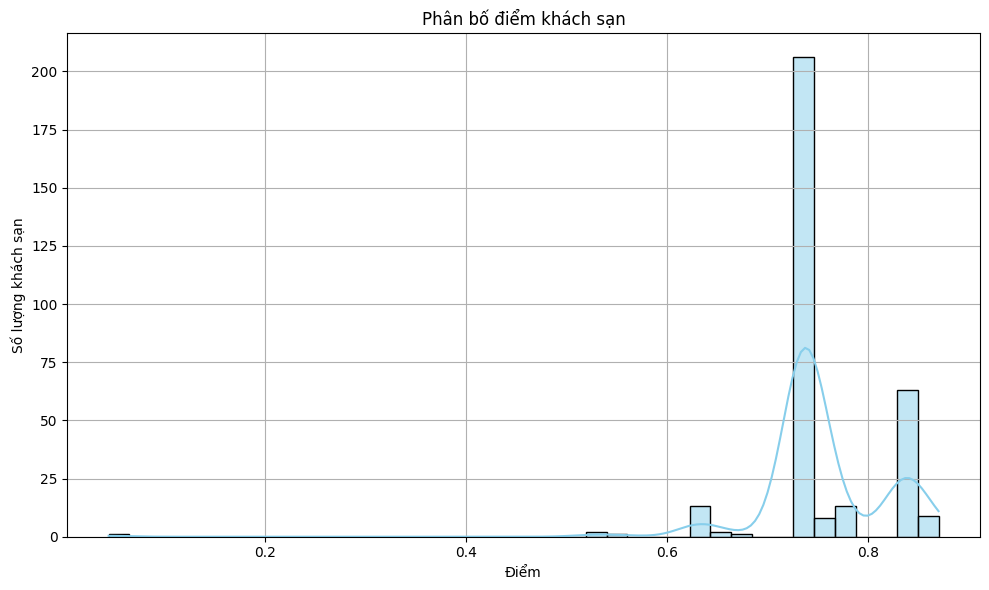

In [13]:
ids_result, score_location = get_score_loaction(query)

print(len(ids_result))
# Lấy danh sách điểm số
scores = list(score_location.values())

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def get_score_star_rating(ids_result: list, query, feature_star_rating = feature_star_rating):
    """
    Tính điểm sao cho các khách sạn dựa trên tiêu chí đánh giá sao.
    """
    feature_star = []
    for data in feature_star_rating:
        if data['id'] in ids_result:
            feature_star.append(data)

    # 2. Filter star rating
    if query.get('stars_rating') not in [None, '', []]:
        result_stars_hotels_score = fgsp.get_score_rating(query, feature_star)
    else:
        result_stars_hotels_score = []
        for hotel in feature_star_rating:
            result_stars_hotels_score.append({
                'id': hotel['id'],
                'score_rating': 0  
            })
    result_stars_hotels_score = {item['id']: item['score_rating'] for item in result_stars_hotels_score}

    keys_to_remove = [k for k, v in result_stars_hotels_score.items() if v < 0.7]
    for k in keys_to_remove:
        del result_stars_hotels_score[k]

    print(f"🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.")

    return list(result_stars_hotels_score.keys()), result_stars_hotels_score

🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.
307


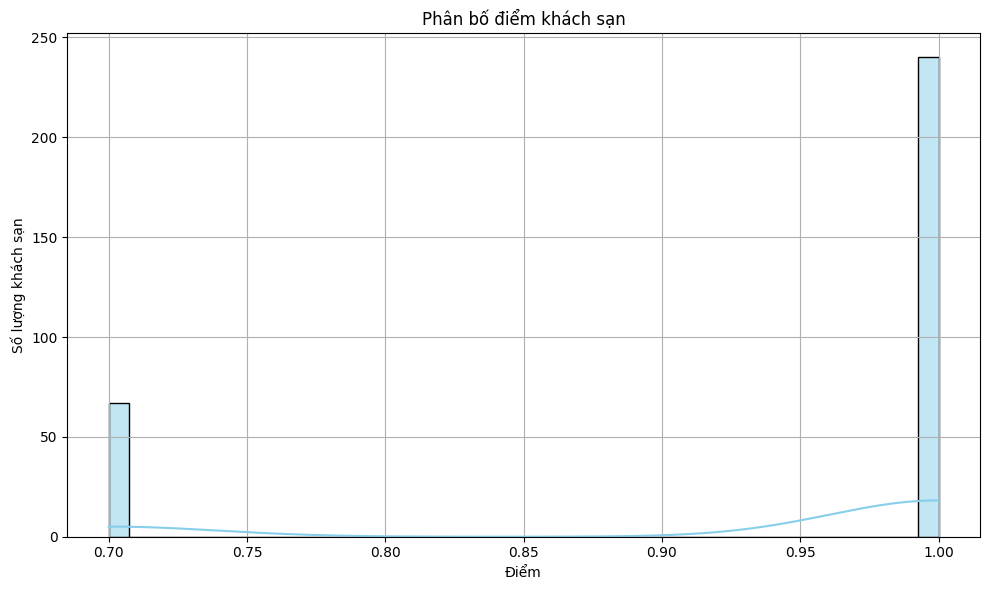

In [15]:
ids_result, score_star_rating = get_score_star_rating(ids_result, query)
print(len(ids_result))

# Lấy danh sách điểm số
scores = list(score_star_rating.values())

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def get_score_price(ids_result, query, feature_detail_room = feature_detail_room):
    # mapping
    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)

    # 3. Filter theo giá
    price = query.get('price_range') # xử lý input 
    if price not in [None, '', [], (None, None)]:
        result_room_price_score = fgsp.get_price_score(query, detail_room)
        score_price = fgsp.get_max_room_score_per_hotel(result_room_price_score)
    else: 
        score_price = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'hotel_score_price' : 1
            })
        result_room_price_score = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'room_id': price['room_id'],
                'hotel_score_price' : 1
            })

    score_price = {item['id']: item['hotel_score_price'] for item in score_price}
    return score_price, result_room_price_score

307


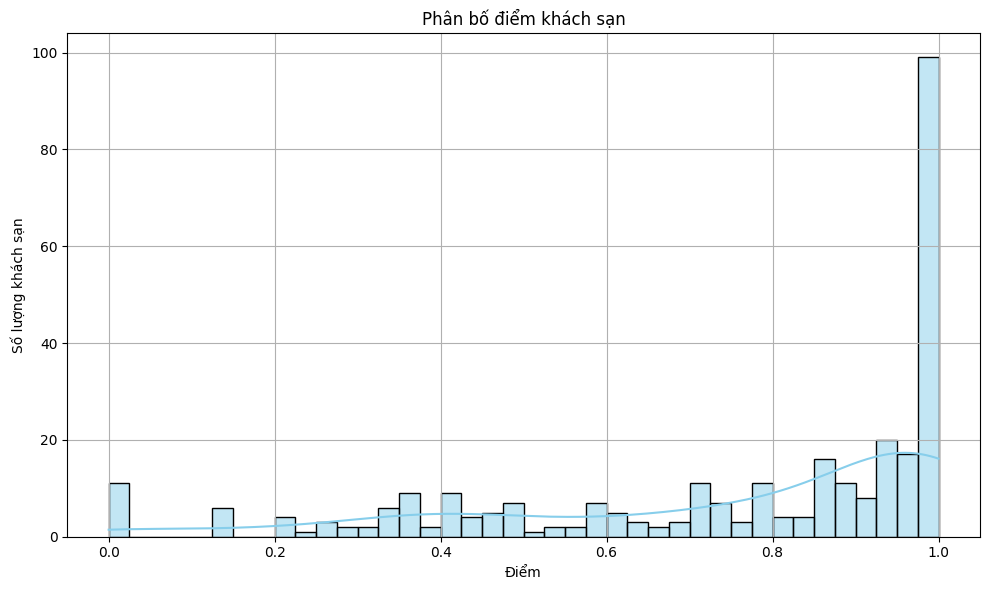

2192


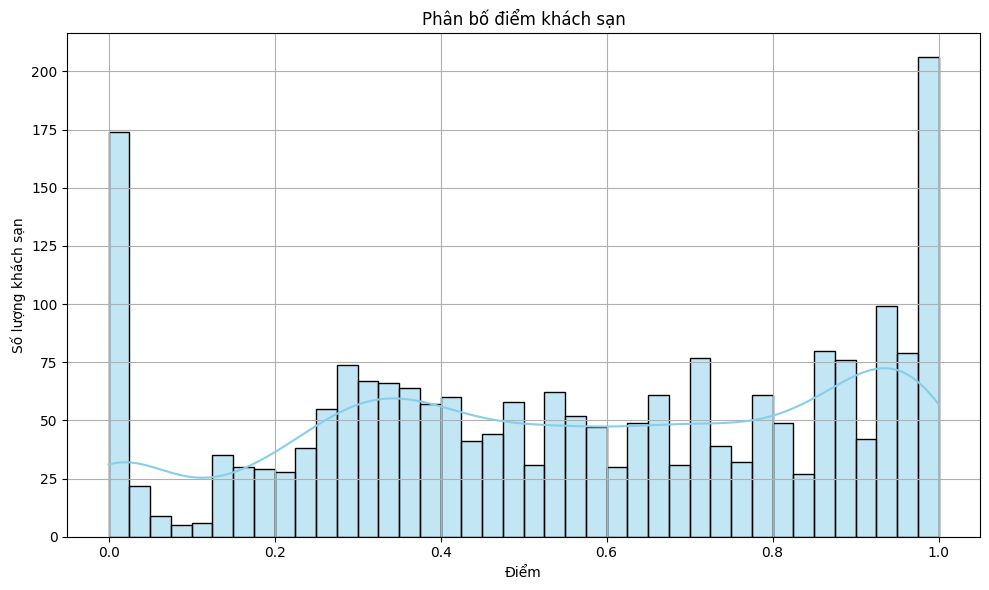

In [17]:
score_price, result_room_price_score = get_score_price(ids_result, query, feature_detail_room)
print(len(score_price))

# Lấy danh sách điểm số
scores = list(score_price.values())

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_price_score))
scores = list([i['room_score_price'] for i in result_room_price_score])
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()


307


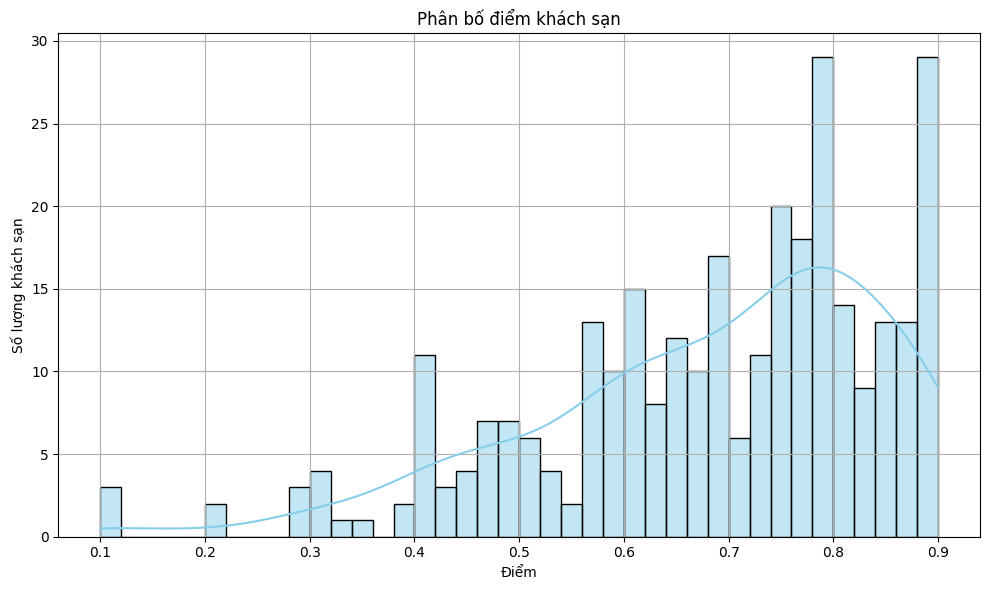

2194


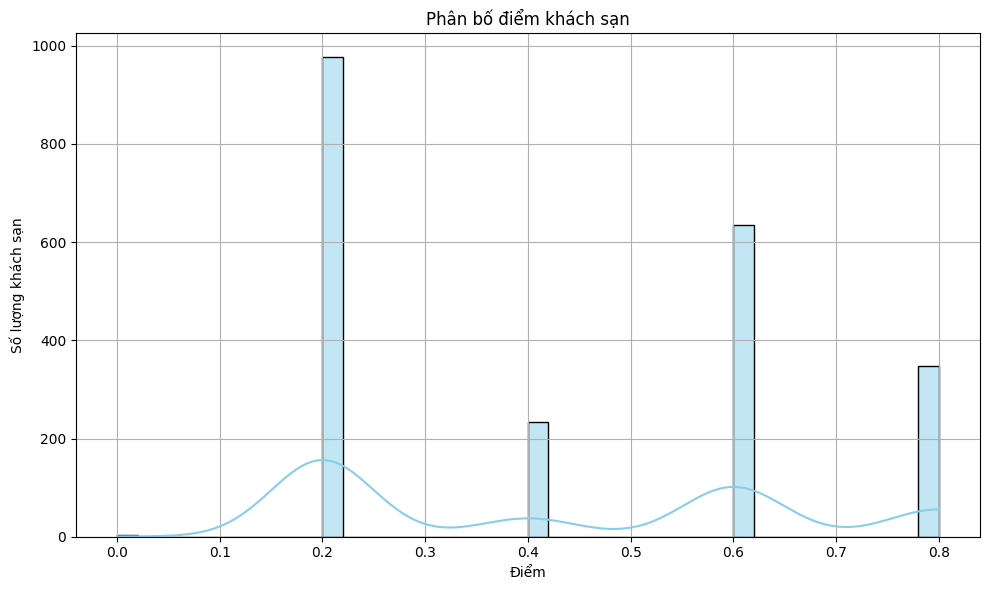

2192


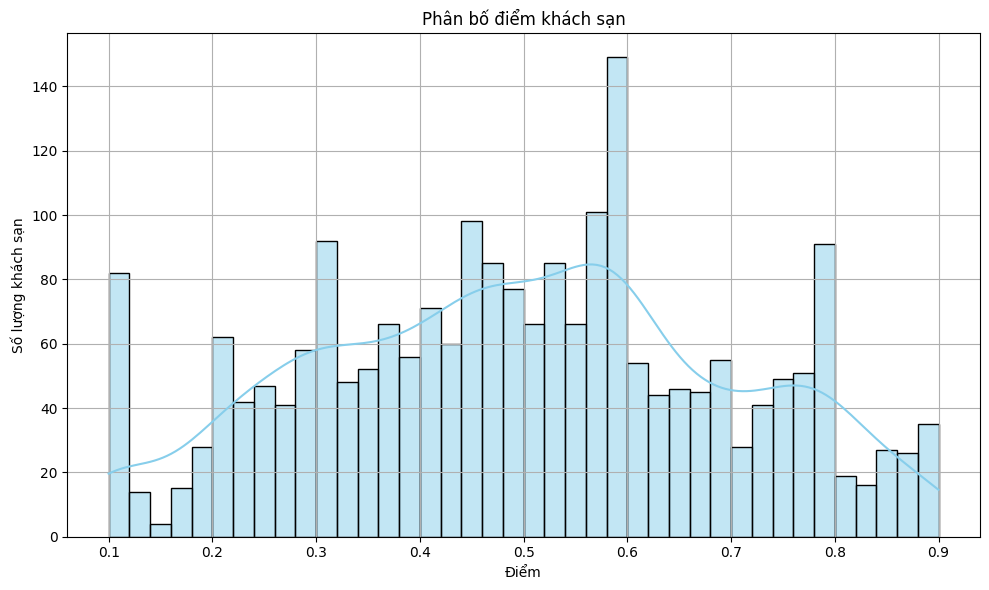

In [18]:
def get_score_room(ids_result, query, feature_detail_room = feature_detail_room, result_room_price_score = result_room_price_score):
    def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
        # Tạo dict nhanh để tra theo (id, room_id)
        room_lookup = {
            (room['id'], room['room_id']): room['room_score']
            for room in rooms
        }

        results = []
        for hotel in hotels:
            key = (hotel['id'], hotel['room_id'])
            if key in room_lookup:
                room_score = room_lookup[key]
                score_price = hotel.get('room_score_price', 0)
                score_room_infor =  weight[0] * room_score + weight[1] * score_price
                #score_room_infor = 0.6 * room_score + 0.4 * score_price 

                results.append({
                    'id': hotel['id'],
                    'room_id': hotel['room_id'],
                    'room_score_price': score_room_infor
                })

        return results


    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)
    score_room_ = rr.get_room_info_score(query, detail_room)
    score_room__ = compute_score_room_infor(result_room_price_score, score_room_) 
    score_room = fgsp.get_max_room_score_per_hotel(score_room__)
    score_room = {item['id']: item['hotel_score_price'] for item in score_room}
    return score_room, score_room_, score_room__

score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query, feature_detail_room, result_room_price_score)
print(len(score_room))
# Lấy danh sách điểm số
scores = list(score_room.values())

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_info_score))
scores = list([i['room_score'] for i in result_room_info_score])
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_info_price_score))
scores = list([i['room_score_price'] for i in result_room_info_price_score])
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
def get_score_policies(ids_result, query, feature_policies=feature_policies):
    print( f" Kiểm tra chính sách phù hợp.")
    filtered_policies = {} 
    for id in ids_result:
        if id in feature_policies:
            filtered_policies[id] = feature_policies[id]

    score_policies = {} 
    if query.get('policies'):
        for id, data in filtered_policies.items():
            score_policies[id] = rp.find_similar_hotel_policies(query['policies'], data)
            # OUTPUT: {'id':'score', ...}
    
    print( f" Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.")
    return score_policies


 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.
307


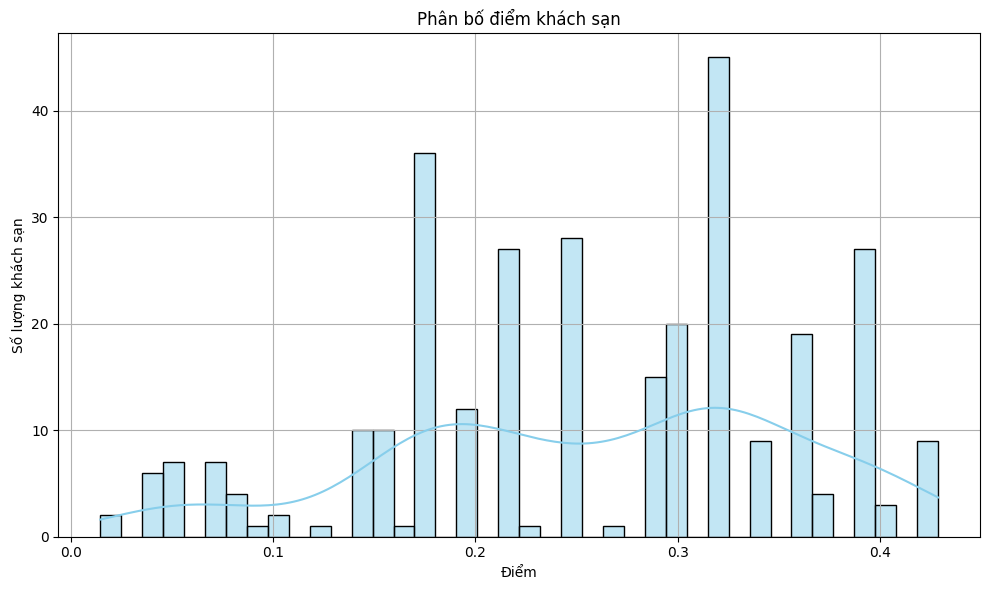

In [20]:
score_policies = get_score_policies(ids_result, query, feature_policies)
print(len(score_policies))
# Lấy danh sách điểm số
scores = list(score_policies.values())

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
307


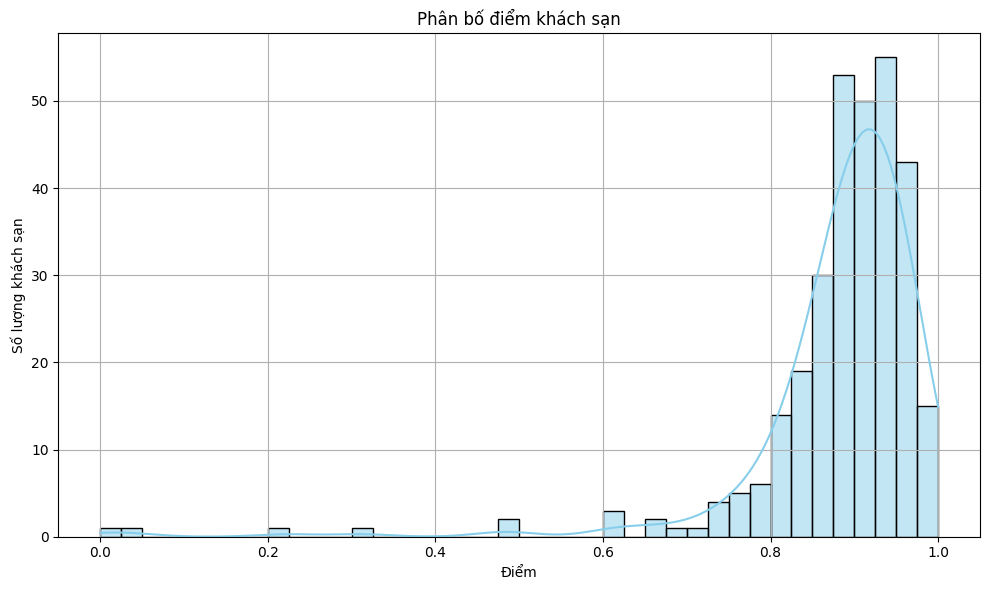

In [21]:
def get_socre_rate_services(ids_result, query, feature_sub_rate=feature_sub_rate):
    """
    Tính điểm cho các khách sạn dựa trên dịch vụ và tiện nghi.
    """
    print( f"🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.") 
    if query['services']:
        print(f"✎ Dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF].")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        result_services = fgr.get_score_sub_rate(services, utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in result_services}
        # OUTPUT: {'id':'score', ...}

    else:
        print(f"✎ Dịch vụ: Rỗng")
        print(f"✎ Dựa vào các tiện ích mà bạn yêu cầu: [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF].")
        designated_utility = set()
        for amenity in query['amenities']:
            cluster = fga.find_clusters([amenity], threshold=0.01)
            designated_utility.update(cluster)
        designated_utility = list(designated_utility)
        print(f"✎ Nên sẽ ưu tiên các khách sạn được đánh cao với các tiêu chí đã phục thuộc các tiện ích trên.")
        score_sub_rate_services = fgr.get_score_sub_rate(designated_utility, 
                                                  utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in score_sub_rate_services}
        # OUTPUT: {'id':'score', ...}
    
    print(" Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.")
    return score_sub_rate_services


score_sub_rate_services = get_socre_rate_services(ids_result, query, feature_sub_rate)
print(len(score_sub_rate_services))
# Lấy danh sách điểm số
scores = list(score_sub_rate_services.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()



In [22]:
def get_score_services(ids_result, query, weights=[0.5, 0.5], beta: float = 0.1, use_median: bool = False,):
    # ============================================================
    if query['services']:
        print(f"🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF]")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        score_services = fga.get_score_services(user_input = list(services), 
                                    List_ids = ids_result, 
                                    weights=weights, 
                                    beta=beta,
                                    use_median=use_median,)
        score_services = {item['id']: item['final_score'] for item in score_services}
        # OUTPUT: {'id':'score', ...} score này chưa chuẩn hóa 
        
        print(f" Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.")
    else:
        score_services = {}
    return score_services

🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.
307


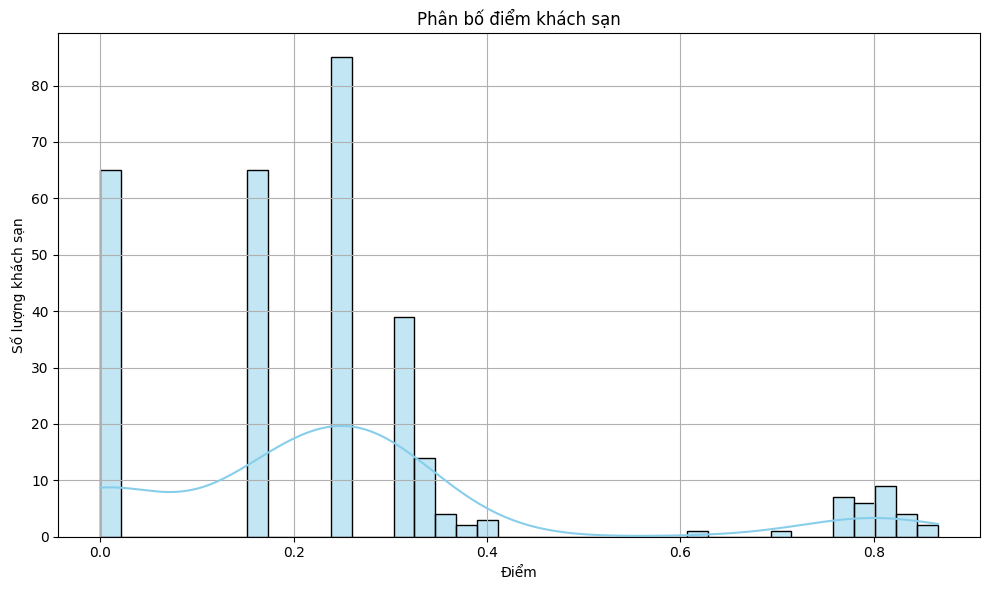

In [23]:
score_services = get_score_services(ids_result, query, weights=[0.5, 0.5], beta=1)
print(len(score_services))
# Lấy danh sách điểm số
scores = list(score_services.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10):
    # ============================================================
    if query['amenities']:
        print(f"🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF]")
        result_facilities_hotel = recommend_faclities_hotel.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )
        result_facilities_room = recommend_faclities_room.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )

        score_facilities = fga.calculate_hotel_scores(result_facilities_hotel, 
                                   result_facilities_room, 
                                   threshold=0.9, 
                                   weight=[0.5, 0.5])
        
        print(f" Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.")

        return score_facilities

🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]TV màn hình phẳng, két an toàn[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.
307


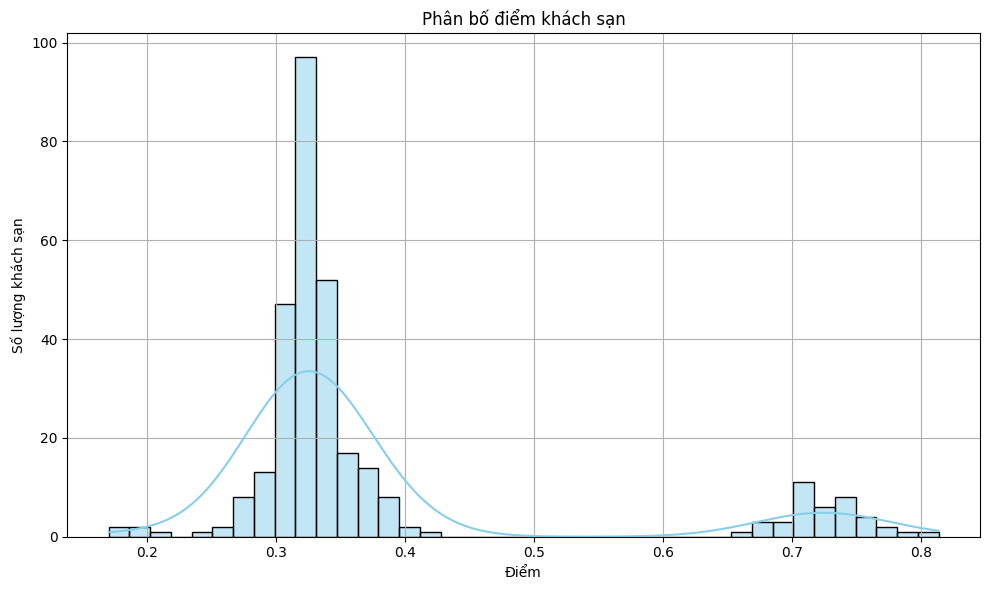

In [25]:
score_facilities = get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10)
print(len(score_facilities))
# Lấy danh sách điểm số
scores = list(score_facilities.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
def score_review_quality(ids_result, print_warning=False):
    return hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)

222


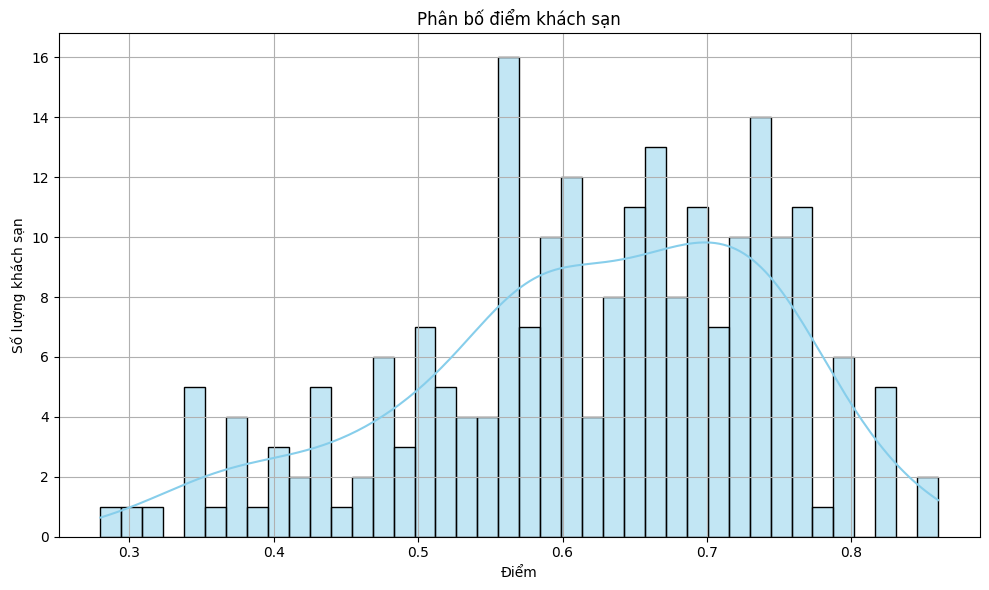

In [27]:
score_quality_review = score_review_quality(ids_result)
print(len(score_quality_review))
# Lấy danh sách điểm số
scores = list(score_quality_review.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Cặp đôi
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Vị trí & môi trường[/bold #80CFFF]
307


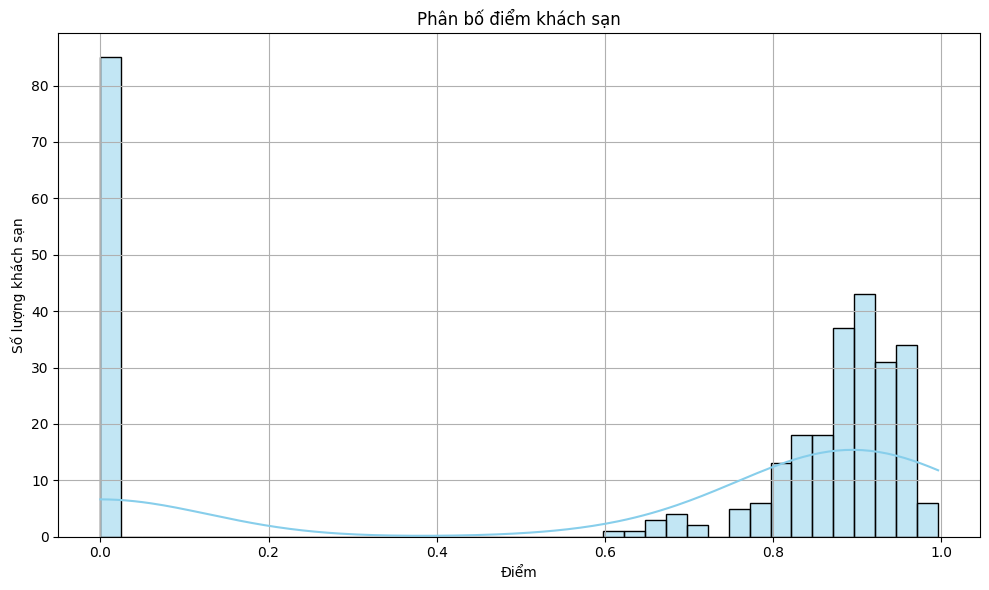

In [28]:
def get_score_review(ids_result, query):
    if not query['country'] and not query['state']: # TH không có thông tin về quốc gia và trạng thái
        if not query['criteria']: # TH không có thông tin về tiêu chí
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                #user_weights = rhr.allocate_weights_with_ratios(), 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
           # OUTPUT : {'id':'score', ...}
        else: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                user_weights = weights, 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
         # OUTPUT : {'id':'score', ...}

    else: # TH có thông tin về quốc gia và trạng thái
        print(f"🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: {query['country']} và trạng thái: {query['state']}")
        result = CF.aggregate_prediction(hotel_ids = ids_result, 
                                            country = query['country'], 
                                            status = query['state'], 
                                            state_model=state_model, 
                                            country_model=country_model, 
                                            print_result=False, 
                                            print_warning=False,
                                            )
        if query['criteria']: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
        else:
            weights = rhr.allocate_weights_with_ratios()

        score_review = {}
        for key, value in result.items():
            score_review[key] = sum(value[key1] * weights[key1] for key1 in value) / sum(weights.values())

    return score_review


score_use_review = get_score_review(ids_result, query)
print(len(score_use_review))

scores = list(score_use_review.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()

307


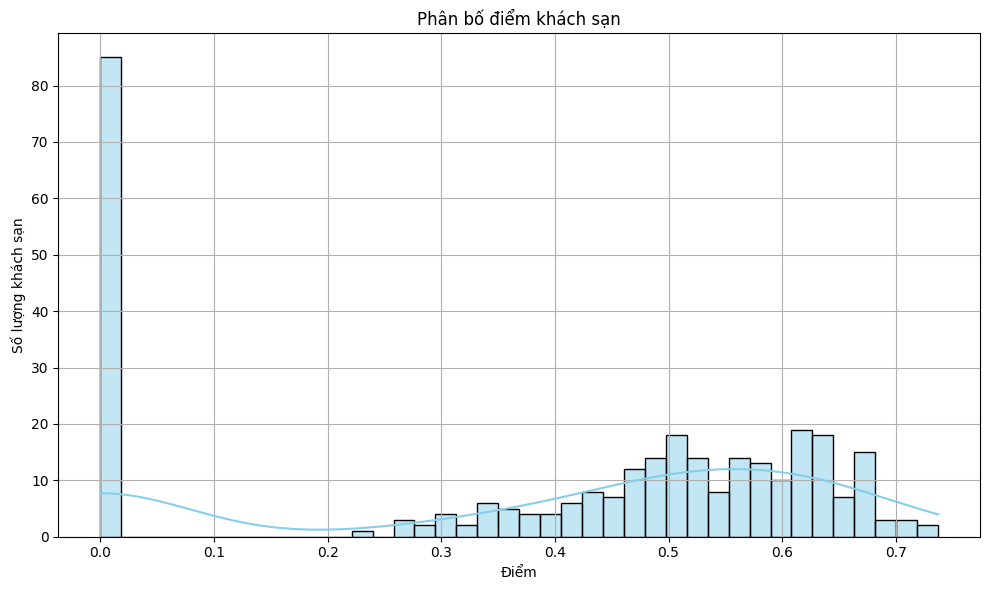

In [29]:
result_final_review_score = rhr.calculate_final_score_from_reviews(
    score_use_review, 
    score_quality_review, 
    w=0.8, 
    q_default=0.5, 
    s_global=0.5,
    threshold=0
)
result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
# OUTPUT : {'id':'score', ...}
print(len(result_final_review_score))

scores = list(result_final_review_score.values())
# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Phân bố điểm khách sạn')
plt.xlabel('Điểm')
plt.ylabel('Số lượng khách sạn')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Giả sử danh sách các dictionary
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    # 'score_review': score_review,
    # 'score_quality_review': score_quality_review,
    # 'result_final_review_score': result_final_review_score,
    # Thêm các score khác
}

# Lấy giao của các ID
common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# Tạo DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))



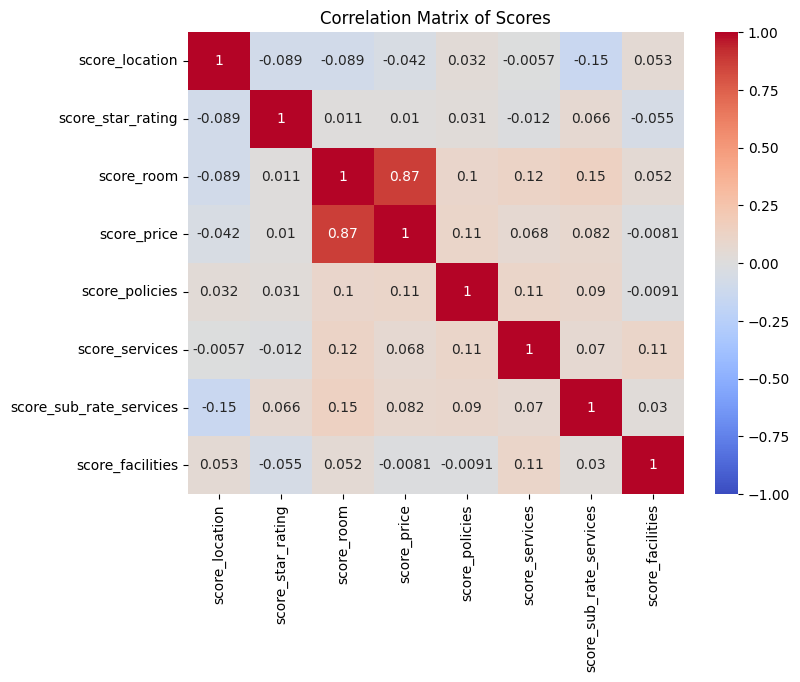

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Scores')
plt.show()

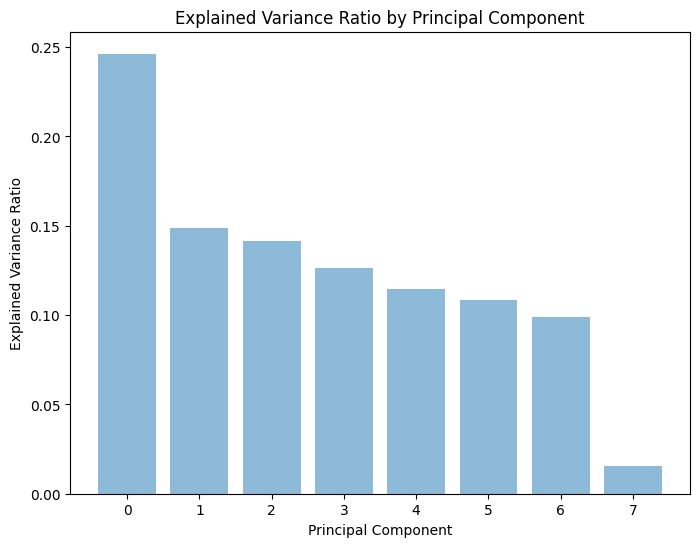

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu (quan trọng cho PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Áp dụng PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Tỷ lệ phương sai được giải thích
explained_variance_ratio = pca.explained_variance_ratio_

# Tạo biểu đồ tỷ lệ phương sai
plt.figure(figsize=(8, 6))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

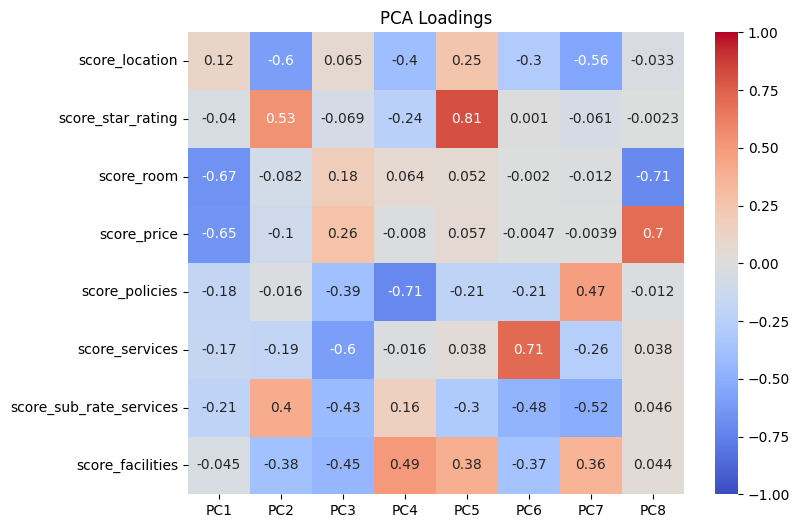

In [33]:
# Tải trọng của các đặc trưng
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=df.columns)

# Vẽ heatmap của tải trọng
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PCA Loadings')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
from uuid import uuid4

# Hàm tính điểm tổng kết
def calculate_total_score(df, weights):
    total_score = np.zeros(len(df))
    for i, col in enumerate(df.columns):
        total_score += weights[i] * df[col].values
    return total_score


def get_top_k_per_feature(df, k):
    """
    Lấy ít nhất k phần tử có giá trị cao nhất cho mỗi cột trong DataFrame,
    bao gồm tất cả các phần tử có giá trị bằng với phần tử thứ k.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số, với các cột là feature và chỉ số là ID.
    - k (int): Số lượng phần tử tối thiểu muốn lấy.

    Returns:
    - top_k_dict (dict): Từ điển với key là tên cột, value là tập hợp các chỉ số của ít nhất k phần tử hàng đầu.
    """
    top_k_dict = {}
    for col in df.columns:
        # Lấy giá trị và chỉ số
        values = df[col].values
        indices = np.arange(len(values))  # Chỉ số gốc
        
        # Sắp xếp theo giá trị giảm dần
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = values[sorted_indices]
        
        # Xác định ngưỡng giá trị
        if len(sorted_values) >= k:
            threshold_value = sorted_values[k - 1]  # Giá trị tại vị trí thứ k
        else:
            threshold_value = sorted_values[-1]  # Giá trị cuối cùng nếu < k phần tử
        
        # Lấy tất cả chỉ số có giá trị >= ngưỡng
        top_k_indices = indices[values >= threshold_value]
        
        # Lưu vào từ điển dưới dạng tập hợp
        top_k_dict[col] = set(top_k_indices)
    
    return top_k_dict

# Hàm kiểm tra tính hợp lý của top k
def evaluate_top_k(df, total_score, k=5, top_k_per_feature = None):
    # Lấy top k ID dựa trên điểm tổng kết
    top_k_indices = np.argsort(total_score)[::-1][:k]
    top_k_ids = set(df.index[top_k_indices])
    top_k_df = df.iloc[top_k_indices]
    
    # Tính top k cho mỗi đặc trưng
    top_k_per_feature = top_k_per_feature
    
    # Đếm số lần ID trong top k không nằm trong top k của mỗi đặc trưng
    valid_recommendations = 0
    for id in top_k_ids:
        for col in df.columns:
            if id not in top_k_per_feature[col]:
                valid_recommendations += 1
    
    # Tính độ đa dạng (phương sai trung bình của các đặc trưng trong top k)
    diversity = top_k_df.std().mean()
    
    return valid_recommendations, diversity

# Hàm kiểm tra trọng số có thỏa mãn ràng buộc [0.1, 0.3]
def is_valid_weights(weights, min_weight=0.1, max_weight=0.3):
    return all(min_weight <= w <= max_weight for w in weights)

# Thử nghiệm với nhiều bộ trọng số
def test_weights(df, k=5, min_weight=0.1, max_weight=0.3, range_ = 5):
    best_weights = None
    best_score = -1
    results = []
    
    # Tạo các tổ hợp trọng số
    weight_ranges = [np.linspace(min_weight, max_weight, range_)] * len(df.columns)  # [0.1, 0.15, 0.2, 0.25, 0.3]
    total_combinations = 0
    valid_weight_combinations = []
    
    # Lọc các tổ hợp trọng số thỏa mãn tổng bằng 1 và nằm trong [0.1, 0.3]
    for weights in tqdm(product(*weight_ranges), total=range_ ** len(df.columns), desc="Generating weights"):
        weights = np.array(weights)
        weights = weights / weights.sum()  # Chuẩn hóa
        if is_valid_weights(weights, min_weight, max_weight):
            valid_weight_combinations.append(weights)
            total_combinations += 1

    top_k_per_feature = get_top_k_per_feature(df, int(k*1))
    # Sử dụng tqdm để theo dõi tiến độ
    for weights in tqdm(valid_weight_combinations, total=total_combinations, desc="Testing weights"):
        total_score = calculate_total_score(df, weights)
        
        valid_recommendations, diversity = evaluate_top_k(df, total_score, k, top_k_per_feature)
        
        # Chấm điểm bộ trọng số: Tối thiểu hóa vi phạm, tối đa hóa độ đa dạng
        score = diversity / (1 + valid_recommendations/k)  # Nghịch đảo vi phạm
        results.append({
            'weights': weights,
            'valid_recommendations': valid_recommendations,
            'diversity': diversity,
            'score': score
        })
        
        if score > best_score:
            best_score = score
            best_weights = weights
    
    return best_weights, results




# Thử nghiệm với nhiều bộ trọng số và nhiều giá trị k
def test_weights_multi_k(df, k_values=[25, 50, 75, 100], min_weight=0.1, max_weight=0.3, range_ = 5):
    results_all = []
    
    # Tạo các tổ hợp trọng số
    weight_ranges = [np.linspace(min_weight, max_weight, range_)] * len(df.columns)  # [0.1, 0.15, 0.2, 0.25, 0.3]
    total_combinations = 0
    valid_weight_combinations = []
    
    # Lọc các tổ hợp trọng số thỏa mãn tổng bằng 1 và nằm trong [0.1, 0.3]
    for weights in tqdm(product(*weight_ranges), total=range_ ** len(df.columns), desc="Generating weights"):
        weights = np.array(weights)
        weights = weights / weights.sum()  # Chuẩn hóa
        if is_valid_weights(weights, min_weight, max_weight):
            valid_weight_combinations.append(weights)
            total_combinations += 1
    
    # Thử nghiệm cho từng giá trị k
    for k in k_values:
        best_weights = None
        best_score = -1
        results_k = []
        
        top_k_per_feature = get_top_k_per_feature(df, int(k*1))
        print(f"\nTesting for k={k}")
        for weights in tqdm(valid_weight_combinations, total=total_combinations, desc=f"Testing weights (k={k})"):
            total_score = calculate_total_score(df, weights)
            violations, diversity = evaluate_top_k(df, total_score, k, top_k_per_feature)
            
            # Chấm điểm bộ trọng số: Tối thiểu hóa vi phạm, tối đa hóa độ đa dạng
            score = diversity / (1 + violations/k)  # Nghịch đảo vi phạm
            results_k.append({
                'weights': weights,
                'violations': violations,
                'diversity': diversity,
                'score': score
            })
            
            if score > best_score:
                best_score = score
                best_weights = weights
        
        
        results_k.sort(key=lambda x: x['score'], reverse=True)

        results_all.append({
            'k': k,
            'best_weights': best_weights,
            'best_score': best_score,
            'results': results_k
        })
    
    return results_all

# Trực quan hóa kết quả
def visualize_results(results_all, df_columns):
    k_values = [r['k'] for r in results_all]
    best_weights = [r['best_weights'] for r in results_all]
    best_scores = [r['best_score'] for r in results_all]
    violations = [min(r['results'], key=lambda x: x['score'])['violations'] for r in results_all]
    diversities = [min(r['results'], key=lambda x: x['score'])['diversity'] for r in results_all]
    
    # Biểu đồ cột cho best_weights
    plt.figure(figsize=(10, 6))
    width = 0.1
    x = np.arange(len(k_values))
    for i, col in enumerate(df_columns):
        plt.bar(x + i * width, [w[i] for w in best_weights], width, label=f'w_{col}')
    plt.xlabel('k')
    plt.ylabel('Weight')
    plt.title('Best Weights for Different k Values')
    plt.xticks(x + width * (len(df_columns) - 1) / 2, k_values)
    plt.legend()
    plt.show()
    plt.close()
    
    # Biểu đồ đường cho Violations, Diversity và Score
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()

        # Biểu đồ đường cho Violations, Diversity và Score
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, diversities, marker='o', label='Diversity')
    plt.plot(k_values, best_scores, marker='o', label='Score')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()




In [35]:
# Giả sử danh sách các dictionary
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    # 'score_review': score_review,
    # 'score_quality_review': score_quality_review,
    # 'result_final_review_score': result_final_review_score,
    # Thêm các score khác
}







---

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.
 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.
🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]TV màn hình phẳng, két an toàn[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.


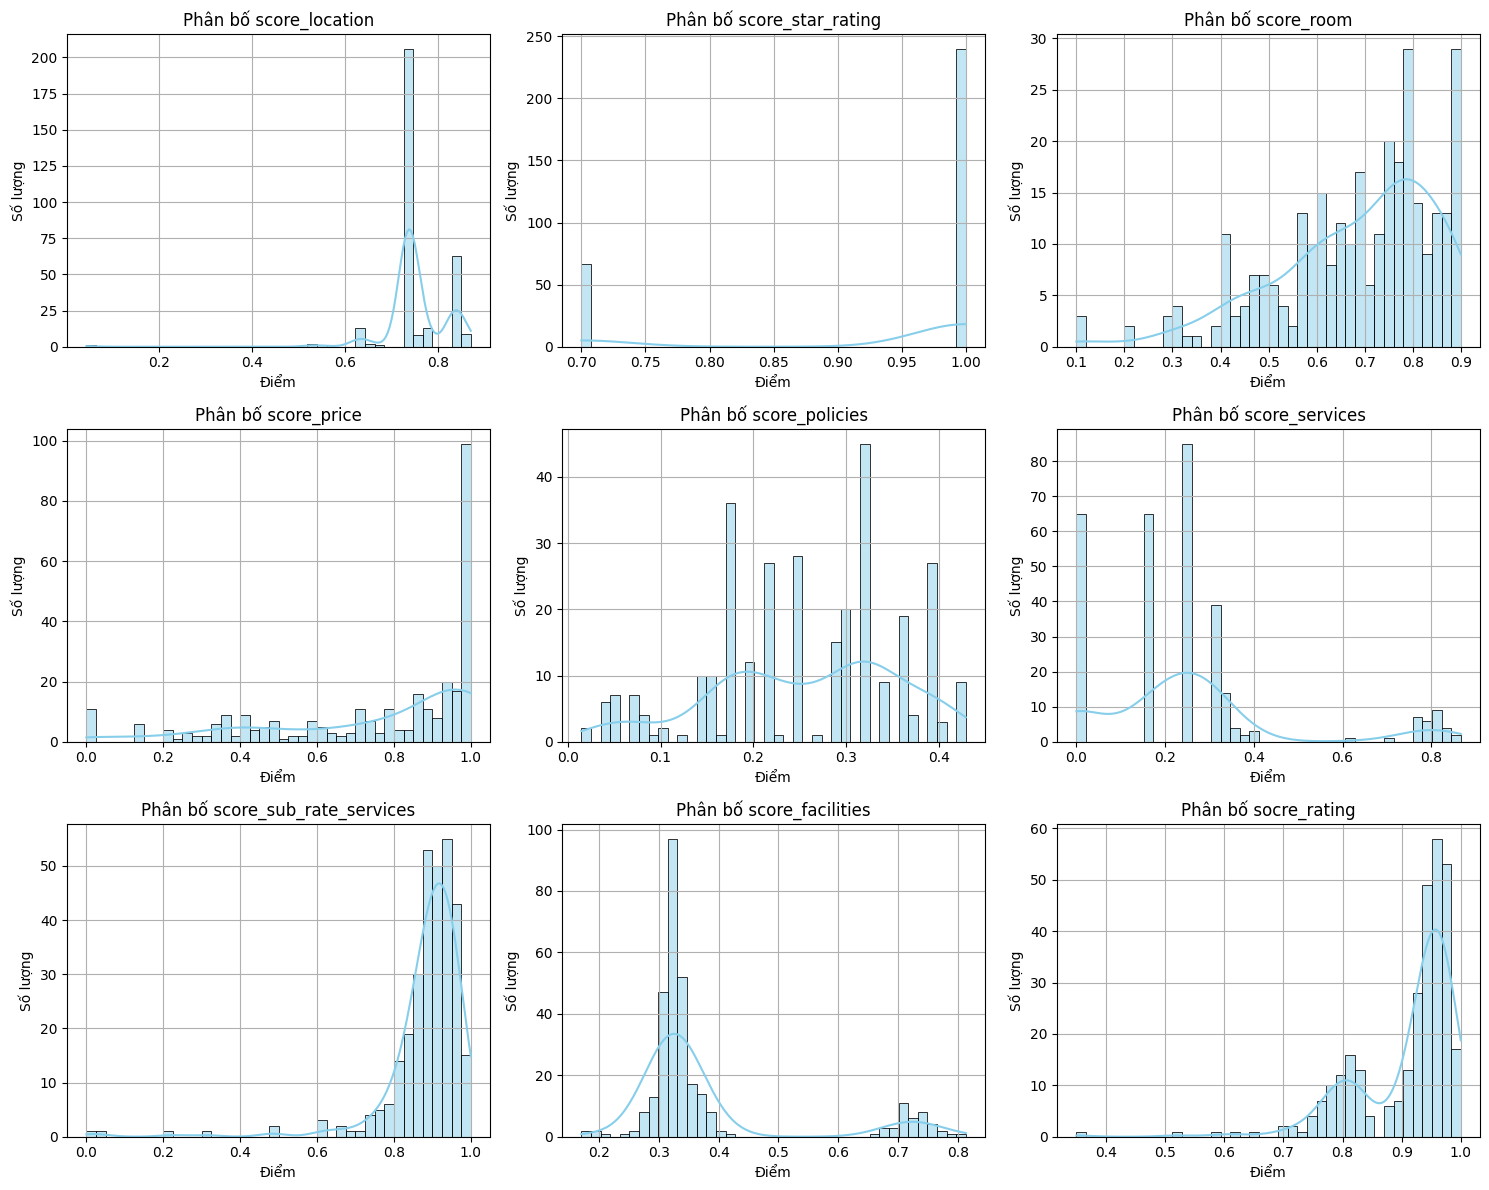

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query)
ids_result, score_star_rating = get_score_star_rating(ids_result, query)
score_price, result_room_price_score = get_score_price(ids_result, query, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query, feature_sub_rate)
score_services = get_score_services(ids_result, query, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))




# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [37]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# Tạo DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)




Generating weights: 100%|██████████| 117649/117649 [00:00<00:00, 199455.00it/s]



Testing for k=10


Testing weights (k=10): 100%|██████████| 51018/51018 [00:18<00:00, 2829.92it/s]



Testing for k=25


Testing weights (k=25): 100%|██████████| 51018/51018 [00:20<00:00, 2464.25it/s]



Testing for k=50


Testing weights (k=50): 100%|██████████| 51018/51018 [00:21<00:00, 2357.64it/s]


In [38]:
# In kết quả
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Trực quan hóa


Results for k=10:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.1, 'w_score_policies': 0.13333333333333333, 'w_score_services': 0.16666666666666669, 'w_score_facilities': 0.2, 'w_socre_rating': 0.3}
Violations: 52, Diversity: 0.1492, Score: 0.0241

Results for k=25:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.23333333333333334, 'w_score_policies': 0.16666666666666669, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 115, Diversity: 0.1485, Score: 0.0265

Results for k=50:
Best weights: {'w_score_location': 0.10000000000000002, 'w_score_price': 0.10000000000000002, 'w_score_policies': 0.23333333333333336, 'w_score_services': 0.20000000000000004, 'w_score_facilities': 0.2666666666666667, 'w_socre_rating': 0.10000000000000002}
Violations: 200, Diversity: 0.1609, Score: 0.0322


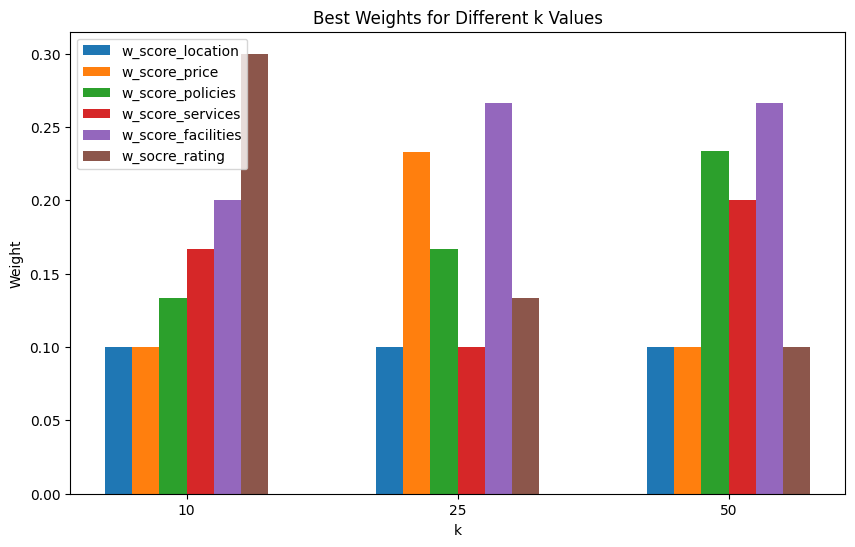

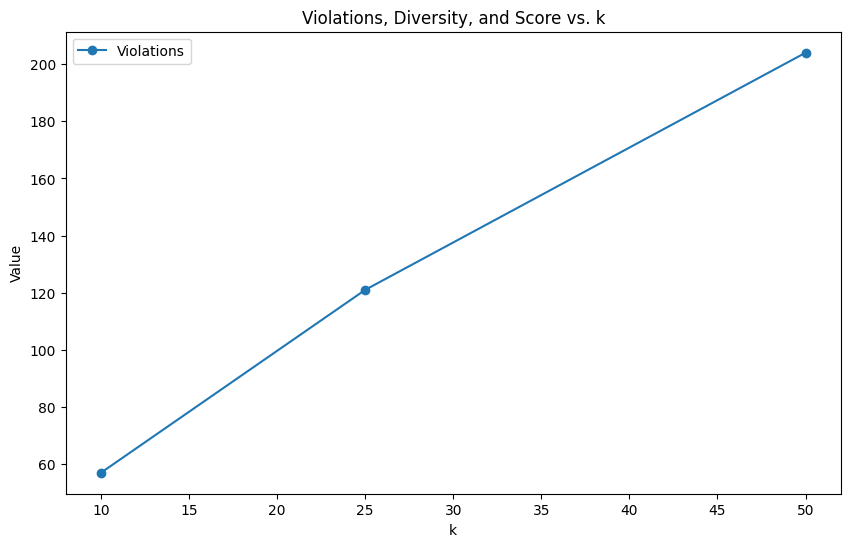

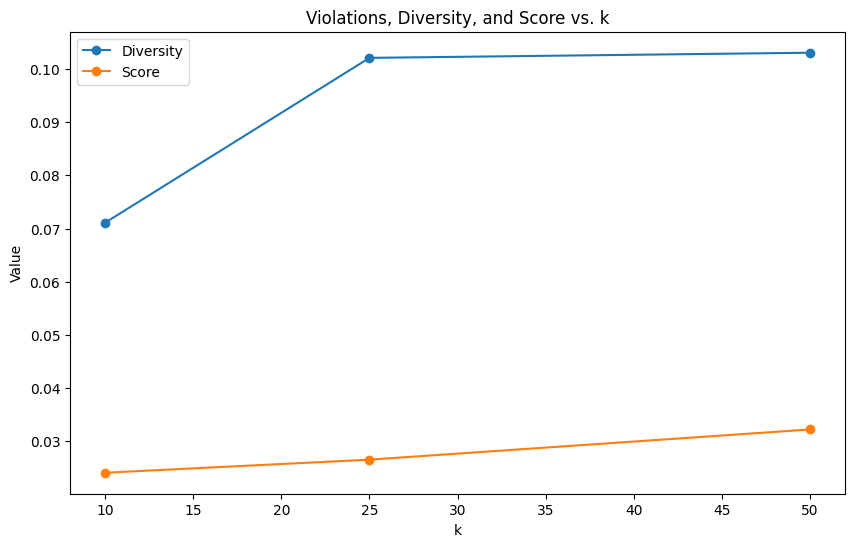

In [39]:
visualize_results(results_all, df.columns)

---

Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Cặp đôi
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Vị trí & môi trường[/bold #80CFFF]


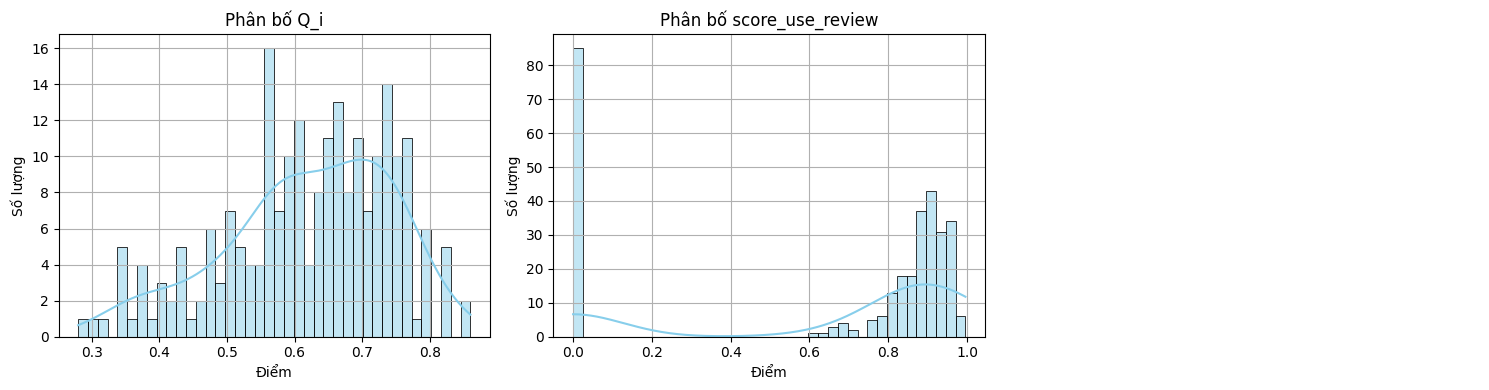

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query)

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [41]:

# Bước 1: Sắp xếp theo score tăng dần
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# Bước 2: Lấy 10 phần tử cách đều nhau
n = len(sorted_items)
num_samples = 10

# Nếu ít hơn 10 phần tử, lấy tất cả
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



In [42]:
for i in result:
    #print(states[i], score_use_review[i])
    print(states[i]['count_review'])


13
18
58
86
120
556
184
351
1002
2784


In [43]:

# Bước 1: Sắp xếp theo score tăng dần
sorted_items = sorted(score_use_review.items(), key=lambda x: x[1])

# Bước 2: Lấy 10 phần tử cách đều nhau
n = len(sorted_items)
num_samples = 10

# Nếu ít hơn 10 phần tử, lấy tất cả
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]

for i in result:
    print(states[i], score_use_review[i])


{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 76, 'count_review_with_image': 9, 'count_long_review': 21, 'total_score': 669.0, 'num_score': 76, 'avg_score': 8.802631578947368} 0.7819427208420302
{'count_review': 220, 'count_review_with_image': 40, 'count_long_review': 93, 'total_score': 2039.0, 'num_score': 220, 'avg_score': 9.268181818181818} 0.8438733734390749
{'count_review': 116, 'count_review_with_image': 3, 'count_long_review': 33, 'total_score': 1095.0, 'num_score': 116, 'avg_score': 9.439655172413794} 0.8828724376460438
{'count_review': 11, 'count_review_with_image': 0, 'count_long_review': 2, 'total_score': 99.0, 'nu

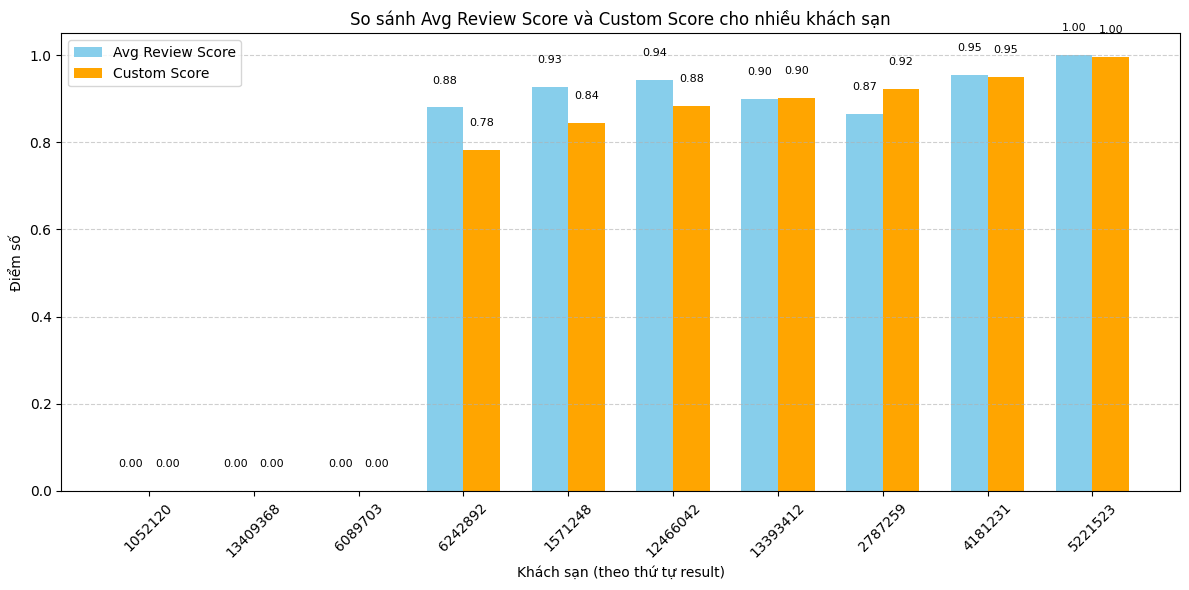

In [44]:


# Lấy dữ liệu
avg_scores = [states[i]['avg_score'] / 10 for i in result]
custom_scores = [score_use_review[i] for i in result]

# Tạo vị trí cho các nhóm cột
x = np.arange(10)  # vị trí của các khách sạn
width = 0.35          # độ rộng của cột

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, avg_scores, width, label='Avg Review Score', color='skyblue')
bars2 = plt.bar(x + width/2, custom_scores, width, label='Custom Score', color='orange')

# Thêm nhãn trên cột
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

# Gắn nhãn, tiêu đề, v.v.
plt.xlabel('Khách sạn (theo thứ tự result)')
plt.ylabel('Điểm số')
plt.title('So sánh Avg Review Score và Custom Score cho nhiều khách sạn')
plt.xticks(x, [f'{i}' for i in result], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [45]:
S_cadj = score_use_review

In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# Tạo DataFrame
common_ids = list(set(Q_i.keys()).intersection(set(S_cadj.keys())))
data = {
    'S_cadj': [S_cadj[id] for id in common_ids],
    'Q_i': [Q_i[id] for id in common_ids]
}
df = pd.DataFrame(data, index=common_ids)
s_global = 0.5
q_default = 0.5
threshold = 0.0

# Phân tích phân phối dữ liệu
def analyze_distribution(df):
    stats = {
        'S_cadj': {
            'mean': df['S_cadj'].mean(),
            'std': df['S_cadj'].std(),
            'variance': df['S_cadj'].var()
        },
        'Q_i': {
            'mean': df['Q_i'].mean(),
            'std': df['Q_i'].std(),
            'variance': df['Q_i'].var()
        }
    }
    # Tính trọng số ban đầu dựa trên phương sai
    var_s_cadj = stats['S_cadj']['variance']
    var_q_i = stats['Q_i']['variance']
    total_var = var_s_cadj + var_q_i
    w_initial = var_q_i / total_var if total_var > 0 else 0.5  # Trọng số dựa trên tỷ lệ phương sai
    
    print("Distribution Analysis:")
    print(f"S_cadj: Mean={stats['S_cadj']['mean']:.4f}, Std={stats['S_cadj']['std']:.4f}, Variance={stats['S_cadj']['variance']:.4f}")
    print(f"Q_i: Mean={stats['Q_i']['mean']:.4f}, Std={stats['Q_i']['std']:.4f}, Variance={stats['Q_i']['variance']:.4f}")
    print(f"Initial w (based on variance): {w_initial:.4f}")
    
    return stats, w_initial

def calculate_fi(df, w, s_global, q_default, threshold):
    fi_scores = []
    for _, row in df.iterrows():
        s_cadj = row['S_cadj']
        q_i = row['Q_i']
    
        # Trường hợp 1: Không có đánh giá (s_adj là NaN)
        if pd.isna(s_cadj):
            fi = s_global * q_default
    
        # Trường hợp 2: Không có quality_score (q_i là NaN)
        elif pd.isna(q_i):
            fi = s_cadj * (1 - w) * q_default
    
        # Trường hợp 3: Q_i < threshold
        elif q_i < threshold:
            fi = s_global * q_default
    
        # Trường hợp 4: Q_i = 0
        elif q_i == 0:
            fi = s_cadj * (1 - w) * q_default
    
        # Trường hợp thông thường: Damped Multiplicative Combination
        else:
            fi = s_cadj * (w * q_i + (1 - w) * q_default)
    
        fi_scores.append(fi)

    return np.array(fi_scores)

def calculate_fi(df, w, s_global, q_default, threshold):
    fi_scores = []
    for _, row in df.iterrows():
        s_cadj = row['S_cadj']
        q_i = row['Q_i']

        fi = (w * s_cadj + (1 - w) * q_i)
        
        fi_scores.append(fi)
    
    return np.array(fi_scores)

# Hàm tính top k
def get_top_k_per_feature(df, k, columns=['S_cadj', 'Q_i']):
    top_k_dict = {}
    for col in columns:
        top_k_indices = np.argsort(df[col].values)[::-1][:min(k, len(df))]
        top_k_dict[col] = set(df.index[top_k_indices])
    return top_k_dict

# Hàm đánh giá top k
def evaluate_top_k(df, fi_scores, k):
    top_k_indices = np.argsort(fi_scores)[::-1][:min(k, len(df))]
    top_k_ids = set(df.index[top_k_indices])
    top_k_df = df.iloc[top_k_indices]
    
    top_k_per_feature = get_top_k_per_feature(df, k)
    
    violations = 0
    for idx in top_k_ids:
        for col in ['S_cadj', 'Q_i']:
            if idx not in top_k_per_feature[col]:
                violations += 1
    
    diversity = top_k_df[['S_cadj', 'Q_i']].std().mean() if len(top_k_df) > 1 else 0
    
    return violations, diversity

# Thử nghiệm với nhiều giá trị w
def test_weights(df, k_values=[25, 50, 75, 100], s_global=0.5, q_default=0.5, threshold=0.3, w_initial=0.5):
    results_all = []
    w_values = np.linspace(max(0.1, w_initial - 0.3), min(0.9, w_initial + 0.3), 20)  # Tập trung quanh w_initial
    
    for k in k_values:
        best_w = None
        best_score = -1
        results_k = []
        
        print(f"\nTesting for k={k}")
        for w in tqdm(w_values, desc=f"Testing weights (k={k})"):
            fi_scores = calculate_fi(df, w, s_global, q_default, threshold)
            violations, diversity = evaluate_top_k(df, fi_scores, k)
            
            score = diversity / (1 + violations)  # Tối thiểu hóa vi phạm, tối đa hóa độ đa dạng
            results_k.append({
                'w': w,
                'violations': violations,
                'diversity': diversity,
                'score': score
            })
            
            if score > best_score:
                best_score = score
                best_w = w
        
        results_k.sort(key=lambda x: x['score'], reverse=True)
        results_all.append({
            'k': k,
            'best_w': best_w,
            'best_score': best_score,
            'results': results_k
        })
    
    return results_all

# Trực quan hóa kết quả
def visualize_results(results_all, w_initial):
    k_values = [r['k'] for r in results_all]
    best_w_values = [r['best_w'] for r in results_all]
    best_scores = [r['best_score'] for r in results_all]
    violations = [min(r['results'], key=lambda x: x['score'])['violations'] for r in results_all]
    diversities = [min(r['results'], key=lambda x: x['score'])['diversity'] for r in results_all]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, best_w_values, marker='o', label='Best w')
    plt.axhline(y=w_initial, color='r', linestyle='--', label='Initial w (variance-based)')
    plt.xlabel('k')
    plt.ylabel('Weight (w)')
    plt.title('Best Weight (w) vs. k')
    plt.legend()
    plt.savefig('best_w_vs_k.png')
    plt.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.plot(k_values, diversities, marker='o', label='Diversity')
    plt.plot(k_values, best_scores, marker='o', label='Score')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()

# Phân tích phân phối và chạy thử nghiệm
stats, w_initial = analyze_distribution(df)
results_all = test_weights(df, k_values=[10, 25, 50], s_global=s_global, q_default=q_default, threshold=threshold, w_initial=w_initial)



Distribution Analysis:
S_cadj: Mean=0.8840, Std=0.0708, Variance=0.0050
Q_i: Mean=0.6201, Std=0.1236, Variance=0.0153
Initial w (based on variance): 0.7530

Testing for k=10


Testing weights (k=10): 100%|██████████| 20/20 [00:00<00:00, 144.10it/s]



Testing for k=25


Testing weights (k=25): 100%|██████████| 20/20 [00:00<00:00, 153.54it/s]



Testing for k=50


Testing weights (k=50): 100%|██████████| 20/20 [00:00<00:00, 132.56it/s]


* $S_csdj$ có trung bình cao hơn so với $Q_i$. Thấy được điểm review người dùng thường cao hơn điểm chất lượng review.
* Độ lệch chuẩn và phương sai của $Q_i$ lớn hơn đáng kể so với $S_cadj$.tức là điểm chất lượng review có khả năng phân biệt các khách sạn tốt hơn.
* Ta có phương sai là mục độ phân tán dữ liệu. một đặt trưng có phương sai lớn hơn thường mang nhiều thông tin hơn. vì nó phản ảnh sự khách biệt rõ rệt giũa các đối tượng. 


In [47]:
# In kết quả
for result in results_all:
    k = result['k']
    best_w = result['best_w']
    print(f"\nResults for k={k}:")
    print(f"Best w: {best_w:.2f}")
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")




Results for k=10:
Best w: 0.90
Violations: 13, Diversity: 0.0567, Score: 0.0041

Results for k=25:
Best w: 0.90
Violations: 26, Diversity: 0.0554, Score: 0.0021

Results for k=50:
Best w: 0.90
Violations: 34, Diversity: 0.0531, Score: 0.0015


---

In [76]:
query_many_hotels = {
    'province': 'Thành phố Hồ Chí Minh',
    'nearby_places': ['Chợ Bến Thành', 'Phố đi bộ Nguyễn Huệ'],
    'is_near_center': True,
    'public_transport_access': ['trạm xe buýt', 'ga tàu'],
    'price_range': (500000, 2000000),
    'stars_rating': 4,
    'services': ['Dịch vụ sự kiện & hỗ trợ đặc biệt', 'Tiện ích giải trí & spa'],
    'criteria': ['Vị trí & môi trường', 'Dịch vụ & nhân viên'],
    'amenities': ['TV màn hình phẳng', 'máy lạnh', 'quầy bar mini'],
    
    'booking_flexibility': ['hủy miễn phí'],
    'distance_to_city_center': 5,
    'capacity': 2,
    'country': 'Việt Nam',
    'state': 'Cặp đôi',
    'policies': {
        'Nhận phòng': '14:00-23:00',
        'Trả phòng': '7:00-12:00',
        'Hủy đặt phòng/ Trả trước': 'Hủy miễn phí trong vòng 24h',
        'Vật nuôi': 'Không cho phép',
    },
    'room_type': 'Double Room',
    'included_breakfast': True,
    'room_level': '',
    'bed_type': '1 giường đôi lớn',
    'area': 35,
    'room_view': ['Ban công']
}


In [69]:
ids_result, score_location = get_score_loaction(query_many_hotels)

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.


In [72]:
score_location

{'257543': 0.8299,
 '264198': 0.8299,
 '10128837': 0.825,
 '294771': 0.825,
 '2597342': 0.8246,
 '11971962': 0.82,
 '264986': 0.82,
 '1312425': 0.8199,
 '10012516': 0.38,
 '1002711': 0.38,
 '10052199': 0.38,
 '10059536': 0.38,
 '10059845': 0.38,
 '10112773': 0.38,
 '10175818': 0.38,
 '10230604': 0.38,
 '10257028': 0.38,
 '10257358': 0.38,
 '10322238': 0.38,
 '10335019': 0.38,
 '10367890': 0.38,
 '10410565': 0.38,
 '10505705': 0.38,
 '10533390': 0.38,
 '10577278': 0.38,
 '10600192': 0.38,
 '10618677': 0.38,
 '10636046': 0.38,
 '1063721': 0.38,
 '10668578': 0.38,
 '10868832': 0.38,
 '1087399': 0.38,
 '10874751': 0.38,
 '10915959': 0.38,
 '10967940': 0.38,
 '10973516': 0.38,
 '10978493': 0.38,
 '1097973': 0.38,
 '10980611': 0.38,
 '1102388': 0.38,
 '11058407': 0.38,
 '11061532': 0.38,
 '1108901': 0.38,
 '11099373': 0.38,
 '11108037': 0.38,
 '11110404': 0.38,
 '11161251': 0.38,
 '11186552': 0.38,
 '11192005': 0.38,
 '11192379': 0.38,
 '11203515': 0.38,
 '11205740': 0.38,
 '11212692': 0.38,

In [74]:
utils.filter_matching_elements(ids_result, feature_url)

[{'id': '10012516',
  'url': 'https://www.booking.com/hotel/vn/t-zone-house.vi.html?checkin=2025-03-20&checkout=2025-03-21'},
 {'id': '10012717',
  'url': 'https://www.booking.com/hotel/vn/chez-lotus-rose.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '1002711',
  'url': 'https://www.booking.com/hotel/vn/iris.vi.html?checkin=2025-03-25&checkout=2025-03-26'},
 {'id': '10034269',
  'url': 'https://www.booking.com/hotel/vn/luxury-rooms.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10052199',
  'url': 'https://www.booking.com/hotel/vn/chez-lotus-vn.vi.html?checkin=2025-03-20&checkout=2025-03-21'},
 {'id': '10059536',
  'url': 'https://www.booking.com/hotel/vn/ecodotel-apartment-2.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10059845',
  'url': 'https://www.booking.com/hotel/vn/camelia-108-le-lai.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10105817',
  'url': 'https://www.booking.com/hotel/vn/la-vie-saigon-homestay.vi.html?checkin=2025-05

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.
 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt, Tiện ích giải trí & spa[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt, Tiện ích giải trí & spa[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.
🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]TV màn hình phẳng, máy lạnh, quầy bar mini[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.
510


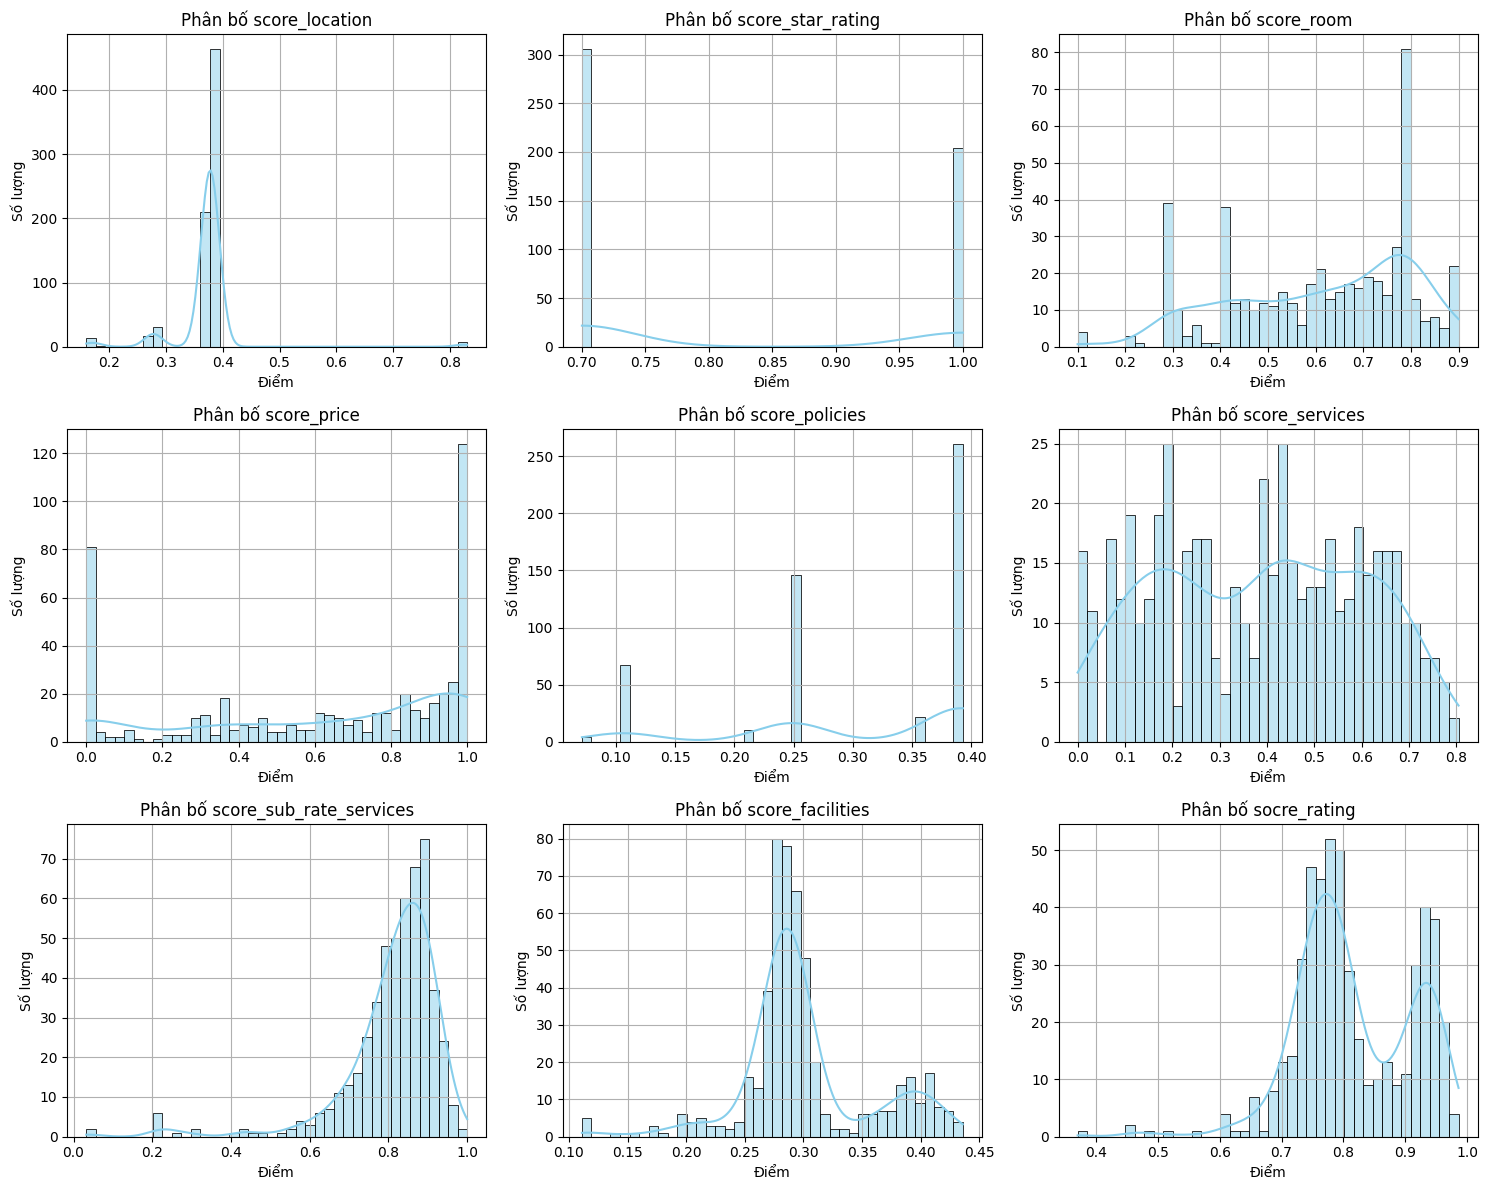

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_many_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_many_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_many_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_many_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_many_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_many_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_many_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_many_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [79]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# Tạo DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In kết quả
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Trực quan hóa


Generating weights:   0%|          | 0/117649 [00:00<?, ?it/s]

Generating weights: 100%|██████████| 117649/117649 [00:00<00:00, 198216.60it/s]



Testing for k=10


Testing weights (k=10): 100%|██████████| 51018/51018 [00:18<00:00, 2747.75it/s]



Testing for k=25


Testing weights (k=25): 100%|██████████| 51018/51018 [00:20<00:00, 2539.49it/s]



Testing for k=50


Testing weights (k=50): 100%|██████████| 51018/51018 [00:23<00:00, 2214.91it/s]



Results for k=10:
Best weights: {'w_score_location': 0.3, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 60, Diversity: 0.1426, Score: 0.0204

Results for k=25:
Best weights: {'w_score_location': 0.3, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 150, Diversity: 0.1065, Score: 0.0152

Results for k=50:
Best weights: {'w_score_location': 0.26666666666666666, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.16666666666666669}
Violations: 300, Diversity: 0.0989, Score: 0.0141


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Cặp đôi
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Vị trí & môi trường, Dịch vụ & nhân viên[/bold #80CFFF]


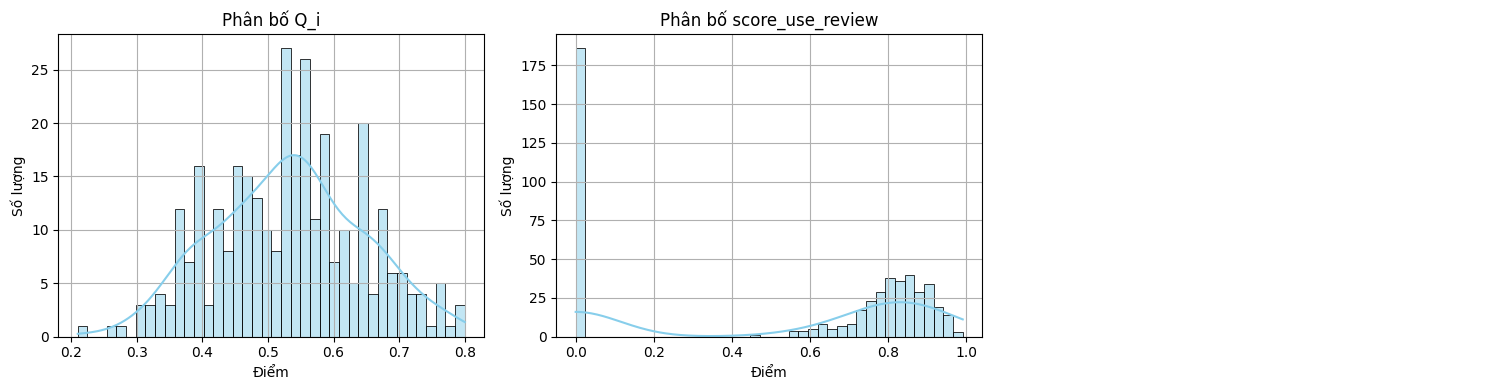

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_many_hotels)

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---

---

In [59]:
query_medium_hotels = {
    'province': 'Lâm Đồng',
    'nearby_places': ['Chợ Đà Lạt', 'Hồ Xuân Hương'],
    'is_near_center': True,
    'public_transport_access': ['bến xe liên tỉnh'],
    'price_range': (300000, 800000),
    'stars_rating': 3,
    'services': ['Dịch vụ vận chuyển & bãi đỗ xe'],
    'criteria': ['Giá trị', 'Sạch sẽ'],
    'amenities': ['TV', 'máy sưởi'],

    'booking_flexibility': ['hủy miễn phí', 'thanh toán khi nhận phòng'],
    'distance_to_city_center': 3,
    'capacity': 2,
    'country': 'Việt Nam',
    'state': 'Phòng gia đình',
    'policies': {
        'Nhận phòng': '13:00-22:00',
        'Trả phòng': '6:00-11:00',
        'Vật nuôi': 'Không cho phép',
        'Tiệc tùng': 'Không tổ chức tiệc',
    },
    'room_type': 'Double Room', 
    'included_breakfast': False,
    'room_level': 'Standard',
    'bed_type': '2 giường đơn',
    'area': 25,
    'room_view': ['Cảnh thành phố']
}


🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.
 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ vận chuyển & bãi đỗ xe[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ vận chuyển & bãi đỗ xe[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.
🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]TV, máy sưởi[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.
591


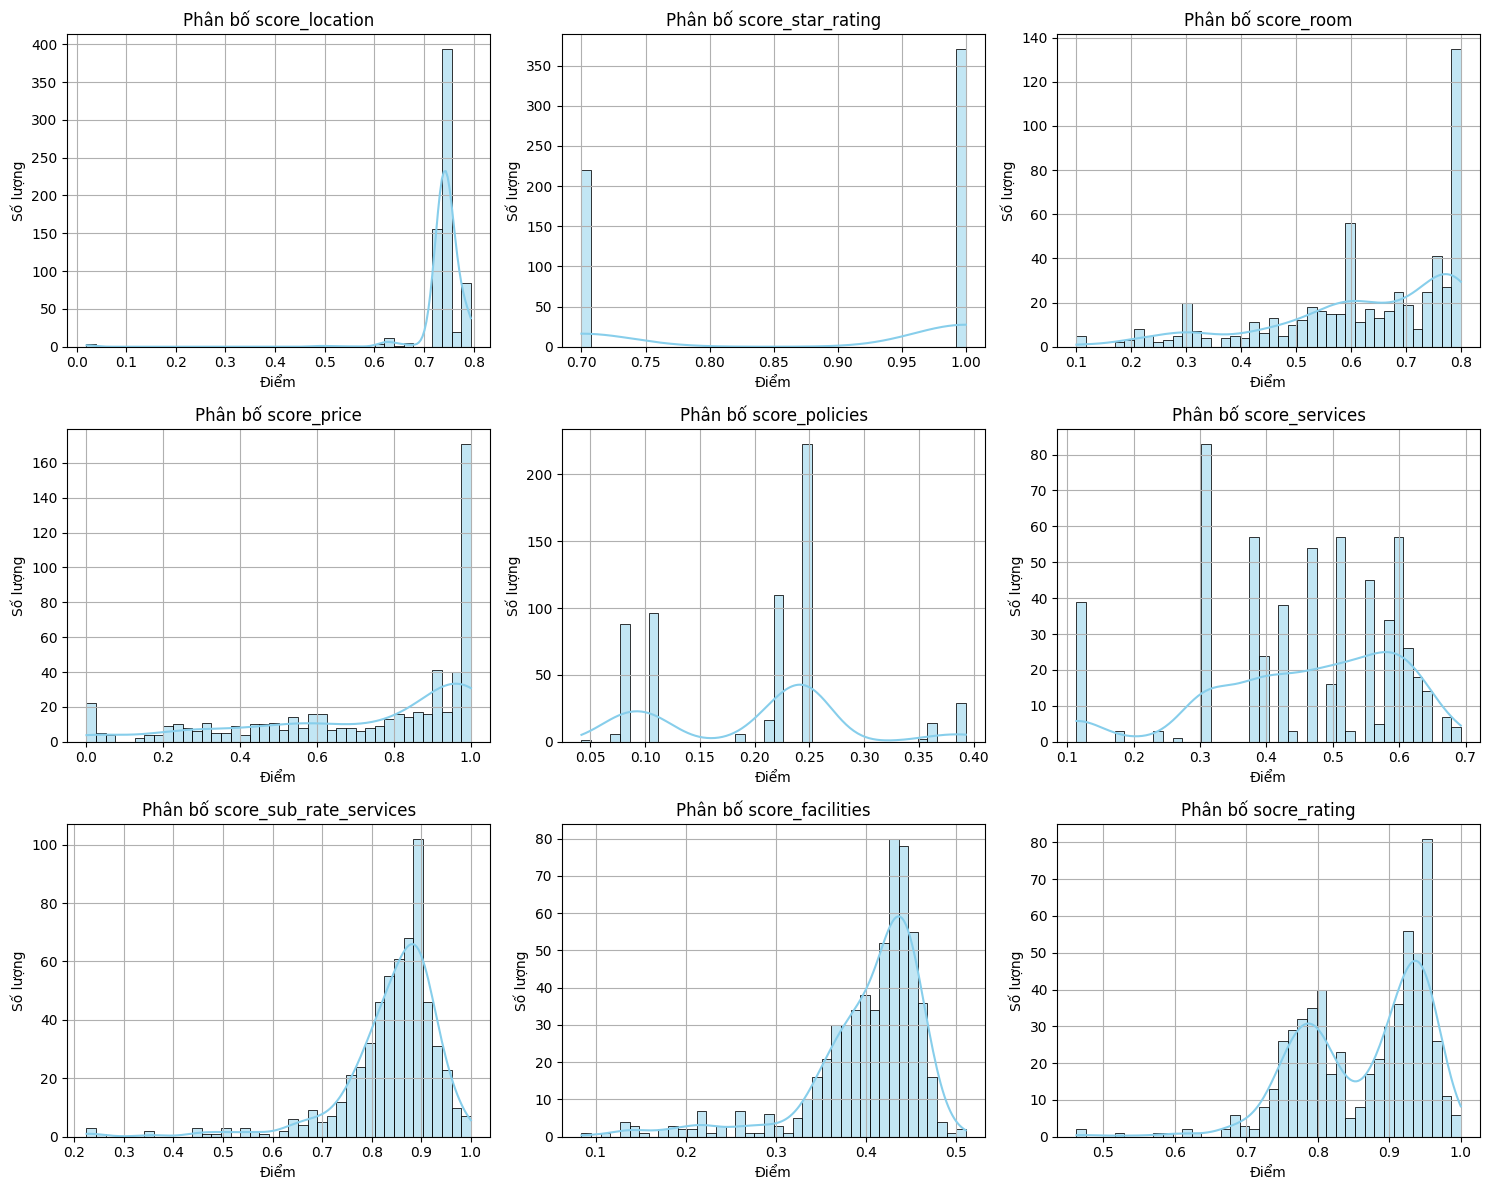

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_medium_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_medium_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_medium_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_medium_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_medium_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_medium_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_medium_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_medium_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [82]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# Tạo DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In kết quả
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Trực quan hóa


Generating weights: 100%|██████████| 117649/117649 [00:00<00:00, 204999.48it/s]



Testing for k=10


Testing weights (k=10): 100%|██████████| 51018/51018 [00:19<00:00, 2555.58it/s]



Testing for k=25


Testing weights (k=25): 100%|██████████| 51018/51018 [00:25<00:00, 2025.74it/s]



Testing for k=50


Testing weights (k=50): 100%|██████████| 51018/51018 [00:28<00:00, 1760.66it/s]


Results for k=10:
Best weights: {'w_score_location': 0.10344827586206896, 'w_score_price': 0.10344827586206896, 'w_score_policies': 0.27586206896551724, 'w_score_services': 0.20689655172413793, 'w_score_facilities': 0.20689655172413793, 'w_socre_rating': 0.10344827586206896}
Violations: 60, Diversity: 0.0513, Score: 0.0073

Results for k=25:
Best weights: {'w_score_location': 0.10714285714285716, 'w_score_price': 0.10714285714285716, 'w_score_policies': 0.28571428571428575, 'w_score_services': 0.10714285714285716, 'w_score_facilities': 0.28571428571428575, 'w_socre_rating': 0.10714285714285716}
Violations: 150, Diversity: 0.0604, Score: 0.0086

Results for k=50:
Best weights: {'w_score_location': 0.16666666666666669, 'w_score_price': 0.1, 'w_score_policies': 0.3, 'w_score_services': 0.1, 'w_score_facilities': 0.1, 'w_socre_rating': 0.23333333333333334}
Violations: 300, Diversity: 0.0648, Score: 0.0093


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Phòng gia đình
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Giá trị, Sạch sẽ[/bold #80CFFF]


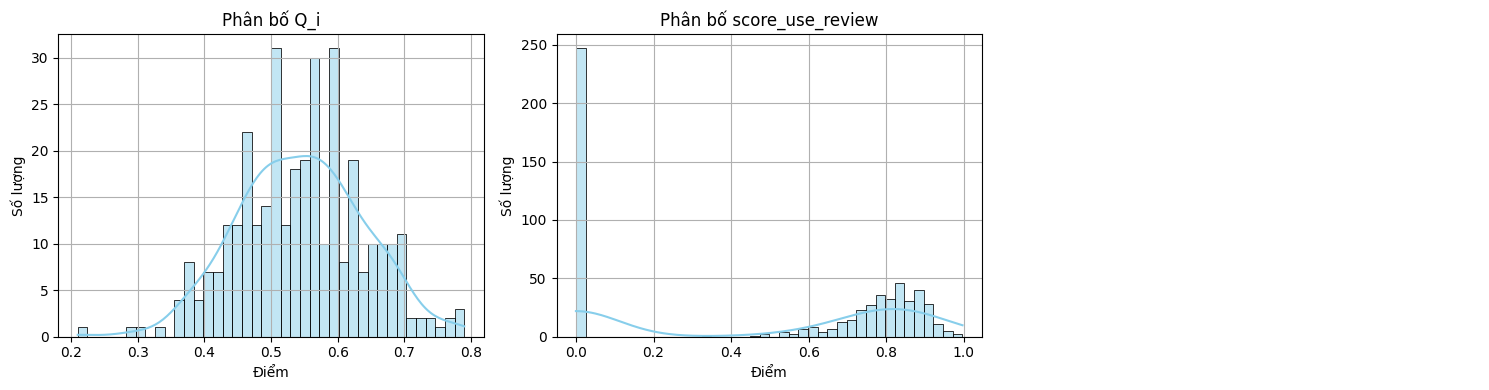

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_medium_hotels)

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:

# Bước 1: Sắp xếp theo score tăng dần
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# Bước 2: Lấy 10 phần tử cách đều nhau
n = len(sorted_items)
num_samples = 10

# Nếu ít hơn 10 phần tử, lấy tất cả
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



---

In [ ]:
.

---

In [65]:
query_few_hotels = {
    'province': 'Hà Giang',
    'nearby_places': ['Mã Pí Lèng', 'Đèo Mèo Vạc'],
    'is_near_center': False,
    'public_transport_access': ['bến xe huyện'],
    'price_range': (150000, 500000),
    'rating': (2, 4),
    'stars_rating': 2,
    'services': ['Dịch vụ ẩm thực'],
    'criteria': ['Vị trí & môi trường'],
    'amenities': ['Quạt máy', 'nhà tắm riêng'],
    'room_type': ['phòng đôi'],
    'booking_flexibility': ['thanh toán khi nhận phòng'],
    'distance_to_city_center': 10,
    'capacity': 2,
    'country': 'Việt Nam',
    'state': 'Khách lẻ',
    'policies': {
        'Nhận phòng': '12:00-21:00',
        'Trả phòng': '6:00-11:00',
        'Vật nuôi': 'Cho phép',
        'Tiệc tùng': 'Không giới hạn',
    },
    'included_breakfast': True,
    'room_level': 'Standard',
    'bed_type': '1 giường đôi nhỏ',
    'area': 15,
    'room_view': ['Cảnh núi']
}


🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.
 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ ẩm thực[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ ẩm thực[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.
🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]Quạt máy, nhà tắm riêng[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.
32


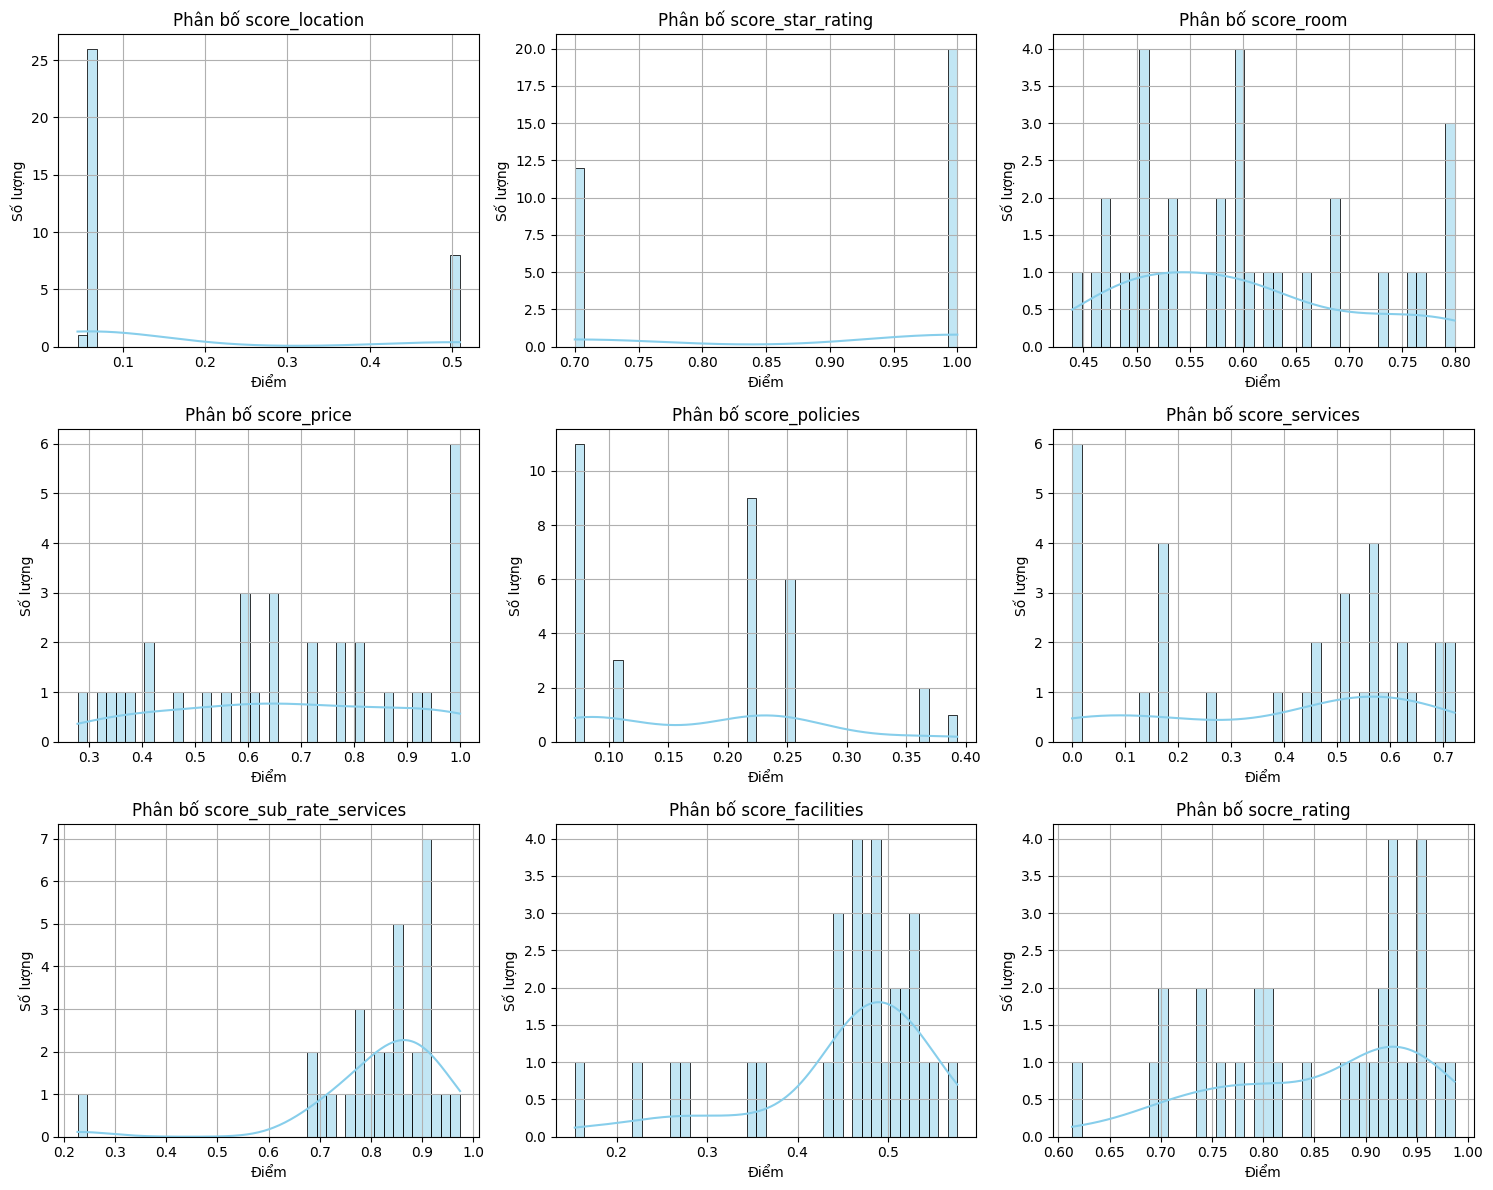

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_few_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_few_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_few_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_few_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_few_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_few_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_few_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_few_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# Tạo DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In kết quả
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Trực quan hóa


Generating weights: 100%|██████████| 117649/117649 [00:00<00:00, 234263.16it/s]



Testing for k=10


Testing weights (k=10): 100%|██████████| 51018/51018 [00:15<00:00, 3291.10it/s]



Testing for k=25


Testing weights (k=25): 100%|██████████| 51018/51018 [00:16<00:00, 3092.08it/s]



Testing for k=50


Testing weights (k=50): 100%|██████████| 51018/51018 [00:18<00:00, 2821.82it/s]



Results for k=10:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.26666666666666666, 'w_score_policies': 0.3, 'w_score_services': 0.1, 'w_score_facilities': 0.1, 'w_socre_rating': 0.13333333333333333}
Violations: 25, Diversity: 0.1364, Score: 0.0390

Results for k=25:
Best weights: {'w_score_location': 0.23333333333333334, 'w_score_price': 0.1, 'w_score_policies': 0.13333333333333333, 'w_score_services': 0.16666666666666669, 'w_score_facilities': 0.13333333333333333, 'w_socre_rating': 0.23333333333333334}
Violations: 22, Diversity: 0.1550, Score: 0.0825

Results for k=50:
Best weights: {'w_score_location': 0.15789473684210528, 'w_score_price': 0.15789473684210528, 'w_score_policies': 0.15789473684210528, 'w_score_services': 0.2105263157894737, 'w_score_facilities': 0.15789473684210528, 'w_socre_rating': 0.15789473684210528}
Violations: 0, Diversity: 0.1627, Score: 0.1627


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Khách lẻ
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Vị trí & môi trường[/bold #80CFFF]


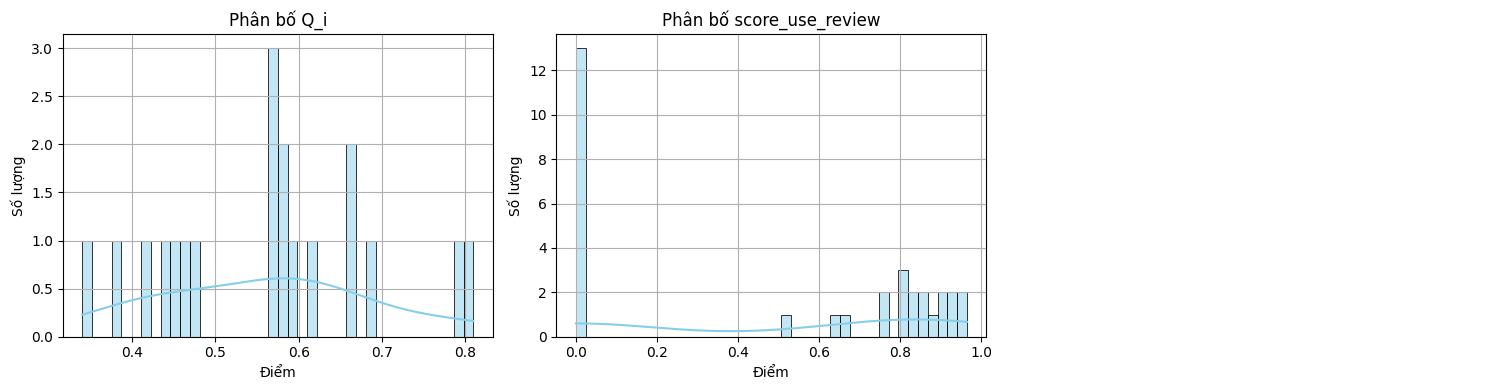

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_few_hotels)

# Giả sử scores là dict chứa các score dạng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# Số lượng biểu đồ cần vẽ
n_scores = len(scores)
n_cols = 3  # số cột trong bảng
n_rows = (n_scores + n_cols - 1) // n_cols  # số hàng

# Tạo figure và axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuyển 2D array về 1D list để dễ truy cập

# Vẽ từng biểu đồ
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Phân bố {key}')
    axes[idx].set_xlabel('Điểm')
    axes[idx].set_ylabel('Số lượng')
    axes[idx].grid(True)

# Ẩn các ô trống nếu có
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

# Bước 1: Sắp xếp theo score tăng dần
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# Bước 2: Lấy 10 phần tử cách đều nhau
n = len(sorted_items)
num_samples = 10

# Nếu ít hơn 10 phần tử, lấy tất cả
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



In [ ]:
for i in result:
    print(states[i], score_use_review[i])



{'count_review': 12, 'count_review_with_image': 2, 'count_long_review': 2, 'total_score': 97.0, 'num_score': 12, 'avg_score': 8.083333333333334} 0.9653510376423281
{'count_review': 50, 'count_review_with_image': 1, 'count_long_review': 9, 'total_score': 399.0, 'num_score': 50, 'avg_score': 7.98} 0.9322732244135795
{'count_review': 27, 'count_review_with_image': 2, 'count_long_review': 5, 'total_score': 231.0, 'num_score': 27, 'avg_score': 8.555555555555555} 0.7572261871151963
{'count_review': 226, 'count_review_with_image': 13, 'count_long_review': 57, 'total_score': 1737.0, 'num_score': 226, 'avg_score': 7.685840707964601} 0.675457550670848
{'count_review': 167, 'count_review_with_image': 3, 'count_long_review': 42, 'total_score': 1369.0, 'num_score': 167, 'avg_score': 8.197604790419161} 0.8025155941331857
{'count_review': 50, 'count_review_with_image': 9, 'count_long_review': 22, 'total_score': 433.0, 'num_score': 50, 'avg_score': 8.66} 0.8446598435867415
{'count_review': 310, 'count

---

In [ ]:

def get_best_hotels(query, top_n = 30): 

    # ============================================================
    print(f"🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm")
    if query.get('nearby_places') or query.get('province'):
        filter_location_hotels = rl.find_hotels_near_location(
            feature_location, query.get('nearby_places', []), query.get('province'), max_distance_km=20
        )
        result_location_hotels_score = rl.get_location_score(
            filter_location_hotels, query.get('nearby_places', []),
            query.get('province'), query.get('is_near_center', False)
        )
    else:
        result_location_hotels_score = feature_location
        for hotel in result_location_hotels_score:
            hotel['location_score'] = 0
    

    score_location = {}
    ids_result = []
    for hotel in result_location_hotels_score:
        ids_result.append(hotel['id'])
        score_location[hotel['id']] = hotel['location_score']

    
    print( f"🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.")


    # ============================================================
    feature_star = []
    for data in feature_star_rating:
        if data['id'] in ids_result:
            feature_star.append(data)

    # 2. Filter star rating
    if query.get('stars_rating') not in [None, '', []]:
        result_stars_hotels_score = fgsp.get_score_rating(query, feature_star)
    else:
        result_stars_hotels_score = []
        for hotel in feature_star_rating:
            result_stars_hotels_score.append({
                'id': hotel['id'],
                'score_rating': 0  
            })
    # OUTPUT: [{'id': '10000593', 'score_rating': 0.5}, {'id': '10000594', 'score_rating': 0.8}, ...]
    # loại bỏ các khách sạn có điểm đánh giá < 0.7.

    # ============================================================

    print( f"🔵 Xem như đã thu được danh sách các ID hotel_room thỏa điều kiện loại phòng và số lượng.")

    score_stars = {} 
    ids_result = []
    for hotel in result_stars_hotels_score:
        ids_result.append(hotel['id'])
        score_stars[hotel['id']] = hotel['score_rating']

    # mapping
    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)

    # 3. Filter theo giá
    price = query.get('price_range') # xử lý input 
    if price not in [None, '', [], (None, None)]:
        result_room_price_score = fgsp.get_price_score(query, detail_room)
        score_price = fgsp.get_max_room_score_per_hotel(result_room_price_score)
    else: 
        score_price = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'hotel_score_price' : 1
            })
        result_room_price_score = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'room_id': price['room_id'],
                'hotel_score_price' : 1
            })

        # OUTPUT [{'id': '10000593', 'hotel_score_price': 0.9847}, ...]
        # kiểm tra giá thực tế so với giá yêu cầu,  nhỏ hơn thì vẫn lấy lớn hơn thì căn nhăc 
    
    score_room_info = rr.get_room_info_score(query, detail_room)
    # OUTPUT : {'id': '10000593', 'room_id': 'RD1000059301', 'room_score': 0.6}

    # ============================================================ 
    # Tính điểm score_room_info
    score_room = compute_score_room_infor(result_room_price_score, score_room_info) 
    

    # ============================================================
    print( f" Kiểm tra chính sách phù hợp.")
    filtered_policies = {} 
    for id in ids_result:
        if id in feature_policies:
            filtered_policies[id] = feature_policies[id]

    score_policies = {} 
    if query.get('policies'):
        for id, data in filtered_policies.items():
            score_policies[id] = rp.find_similar_hotel_policies(query['policies'], data)
            # OUTPUT: {'id':'score', ...}
    
    print( f" Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.")

    # =============================================================
    print( f"🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.") 
    if query['services']:
        print(f"✎ Dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF].")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        result_services = fgr.get_score_sub_rate(services, utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in result_services}
        # OUTPUT: {'id':'score', ...}

    else:
        print(f"✎ Dịch vụ: Rỗng")
        print(f"✎ Dựa vào các tiện ích mà bạn yêu cầu: [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF].")
        designated_utility = set()
        for amenity in query['amenities']:
            cluster = fga.find_clusters([amenity], threshold=0.01)
            designated_utility.update(cluster)
        designated_utility = list(designated_utility)
        print(f"✎ Nên sẽ ưu tiên các khách sạn được đánh cao với các tiêu chí đã phục thuộc các tiện ích trên.")
        score_sub_rate_services = fgr.get_score_sub_rate(designated_utility, 
                                                  utils.filter_matching_elements(ids_result, feature_sub_rate))
        # OUTPUT: {'id':'score', ...}
    
    print(" Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.")


    # ============================================================
    if query['services']:
        print(f"🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF]")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        score_services = fga.get_score_services(user_input = list(services), 
                                    List_ids = ids_result, 
                                    weights=[0.5, 0.5])
        score_services = {item['id']: item['final_score'] for item in score_services}
        # OUTPUT: {'id':'score', ...} score này chưa chuẩn hóa 
        
        print(f" Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.")

    # ============================================================
    if query['amenities']:
        print(f"🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF]")
        result_facilities_hotel = recommend_faclities_hotel.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=0.9, 
            normalization_factor_base=10
        )
        result_facilities_room = recommend_faclities_room.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=0.9, 
            normalization_factor_base=10
        )

        score_facilities = fga.calculate_hotel_scores(result_facilities_hotel, 
                                   result_facilities_room, 
                                   threshold=0.9, 
                                   weight=[0.5, 0.5])
        
        print(f" Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.")

    print(f"Danh sách khách sạn đã tìm kiếm được:")
    result_final_info_score = utils.compute_intersection_score(score_facilities, 
                                                            score_sub_rate_services, 
                                                            score_services,
                                                            score_policies,
                                                            score_location, 
                                                            score_stars,
                                                            weights=(0.2, 0.2, 0.3, 0.1, 0.1, 0.1))
    result_final_info_score = dict(result_final_info_score)
    # OUTPUT : {'id':'score', ...}


    # ============================================================
    print("============================================================")
    print("Giai đoạn 2:")
    print("Kiểm tra phản hòi của khách hàng")
    score_review_quality = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
    if not query['country'] and not query['state']: # TH không có thông tin về quốc gia và trạng thái
        if not query['criteria']: # TH không có thông tin về tiêu chí
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                #user_weights = rhr.allocate_weights_with_ratios(), 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))

            # Tính điểm cuối cùng
            result_final_review_score = rhr.calculate_final_score_from_reviews(
                score_review, 
                score_review_quality, 
                w=0.8, 
                q_default=0.5, 
                s_global=0.7, 
                threshold=0.3
            )
            result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
            # OUTPUT : {'id':'score', ...}
        else: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                user_weights = weights, 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
            result_final_review_score = rhr.calculate_final_score_from_reviews(
                score_review, 
                score_review_quality, 
                w=0.8, 
                q_default=0.5, 
                s_global=0.7, 
                threshold=0.2
            )
            result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
            # OUTPUT : {'id':'score', ...}

    else: # TH có thông tin về quốc gia và trạng thái
        print(f"🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: {query['country']} và trạng thái: {query['state']}")
        result = CF.aggregate_prediction(hotel_ids = ids_result, 
                                            country = query['country'], 
                                            status = query['state'], 
                                            state_model=state_model, 
                                            country_model=country_model, 
                                            print_result=False, 
                                            print_warning=False,
                                            )
        if query['criteria']: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
        else:
            weights = rhr.allocate_weights_with_ratios()

        score_review = {}
        for key, value in result.items():
            score_review[key] = sum(value[key1] * weights[key1] for key1 in value) / sum(weights.values())
        
        result_final_review_score = rhr.calculate_final_score_from_reviews(
            score_review, 
            score_review_quality, 
            w=0.8, 
            q_default=0.5, 
            s_global=0.7, 
            threshold=0.2
        )
        result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
        # OUTPUT : {'id':'score', ...}

    
    # Kết hợp các điểm số
    result_hotel_score = utils.compute_intersection_score(
        result_final_info_score,
        result_final_review_score, 
        weights=(0.7, 0.3)
    )

    detail_score_dicts = [
    score_facilities,
    score_sub_rate_services,
    score_services,
    score_policies,
    score_location,
    score_stars,
    result_final_review_score
    ]
    score_keys = ['score_facilities', 'score_sub_rate_services', 'score_services', 'score_policies', 'score_location', 'score_stars', 'result_final_review_score']

    result_final_score = combine_room_and_hotel_scores_with_details( score_room,result_hotel_score, detail_score_dicts,  score_keys, weight=0.6)

        

    return result_final_score[:top_n]

In [ ]:
result = get_best_hotels(query, top_n = 10)

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm

🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.

🔵 Xem như đã thu được danh sách các ID hotel_room thỏa điều kiện loại phòng và số lượng.

TypeError: unhashable type: 'dict'

In [ ]:
import matplotlib.pyplot as plt

def plot_final_score_breakdown(scores, hotel_id=None, room_id=None):
    """
    Vẽ biểu đồ phân tích điểm final_score theo các thành phần:
        - Hotel Info (Facilities, Services, etc.)
        - Final Review Score
        - Room Info

    Args:
        scores (dict): Dictionary chứa các điểm sau với keys:
            - 'score_facilities', 'score_sub_rate_services', 'score_services',
              'score_policies', 'score_location', 'score_stars',
              'result_final_review_score', 'score_room_infor'
        hotel_id (str/int): Optional hotel identifier
        room_id (str/int): Optional room identifier
    """

    # Trọng số của từng phần
    component_weights = {
        'score_facilities': 0.2,
        'score_sub_rate_services': 0.2,
        'score_services': 0.3,
        'score_policies': 0.1,
        'score_location': 0.1,
        'score_stars': 0.1,
        'result_final_review_score': 0.3,     # phần trong hotel 60%
        'score_room': 0.4               # phần riêng
    }

    # Tính điểm thành phần
    core_score = sum(scores[k] * component_weights[k] for k in [
        'score_facilities', 'score_sub_rate_services', 'score_services',
        'score_policies', 'score_location', 'score_stars'
    ])
    hotel_partial = 0.7 * core_score + 0.3 * scores['result_final_review_score']
    hotel_contribution = 0.6 * hotel_partial
    room_contribution = 0.4 * scores['score_room']
    final_score = hotel_contribution + room_contribution

    # Chuẩn bị dữ liệu để vẽ
    bar_parts = {
        'Hotel Info (Facilities + Services + Location + etc.)': 0.6 * 0.7 * core_score,
        'Hotel Info (Final Review)': 0.6 * 0.3 * scores['result_final_review_score'],
        'Room Info': 0.4 * scores['score_room']
    }

    # Vẽ biểu đồ
    fig, ax = plt.subplots(figsize=(10, 2))
    left = 0
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']

    for i, (label, value) in enumerate(bar_parts.items()):
        ax.barh(0, value, left=left, label=f'{label}: {value:.2f}', color=colors[i])
        left += value

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    title = f"Final Score Breakdown = {final_score:.3f}"
    if hotel_id is not None:
        title += f" | Hotel ID: {hotel_id}"
    if room_id is not None:
        title += f" | Room ID: {room_id}"
    ax.set_title(title)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout()
    plt.show()




In [ ]:
import matplotlib.pyplot as plt

def plot_final_score_breakdown(scores, hotel_id=None, room_id=None):
    """
    Vẽ biểu đồ phân tích chi tiết final_score với đầy đủ các yếu tố.
    """
    # Trọng số ban đầu của từng yếu tố trong hotel_info
    hotel_weights = {
        'score_facilities': 0.2,
        'score_sub_rate_services': 0.2,
        'score_services': 0.3,
        'score_policies': 0.1,
        'score_location': 0.1,
        'score_stars': 0.1,
    }

    # Trọng số theo công thức final_score
    contributions = {}
    for k, w in hotel_weights.items():
        # 60% hotel * 70% hotel_info * w
        contributions[k] = 0.6 * 0.7 * w * scores[k]

    # Final review
    contributions['result_final_review_score'] = 0.6 * 0.3 * scores['result_final_review_score']

    # Room info
    contributions['score_room'] = 0.4 * scores['score_room']

    # Tổng điểm cuối cùng
    final_score = sum(contributions.values())

    # Tạo danh sách labels và giá trị để vẽ
    labels = {
        'score_facilities': 'Facilities',
        'score_sub_rate_services': 'Sub-Rate Services',
        'score_services': 'Services',
        'score_policies': 'Policies',
        'score_location': 'Location',
        'score_stars': 'Stars',
        'result_final_review_score': 'Final Review Score',
        'score_room': 'Room Info'
    }

    colors = ['#66c2a5', '#a6d854', '#ffd92f', '#e78ac3',
              '#8da0cb', '#fc8d62', '#e5c494', '#b3b3b3']

    fig, ax = plt.subplots(figsize=(12, 2.5))
    left = 0

    for i, (key, value) in enumerate(contributions.items()):
        label = labels.get(key, key)
        ax.barh(0, value, left=left, label=f'{label}: {value:.3f}', color=colors[i])
        left += value

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    title = f"Final Score Breakdown = {final_score:.3f}"
    if hotel_id is not None:
        title += f" | Hotel ID: {hotel_id}"
    if room_id is not None:
        title += f" | Room ID: {room_id}"
    ax.set_title(title)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_results(result, feature_url):
    # Tạo dict để tra nhanh từ list feature_url
    url_dict = {item["id"]: item["url"] for item in feature_url}

    for item in result:
        hotel_id = item['id']
        room_id = item['room_id']

        # In ra URL nếu có
        if hotel_id in url_dict:
            print(f"Hotel ID: {hotel_id} | URL: {url_dict[hotel_id]}")
        else:
            print(f"Hotel ID: {hotel_id} | URL not found")

        plot_final_score_breakdown(item, hotel_id, room_id)


Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

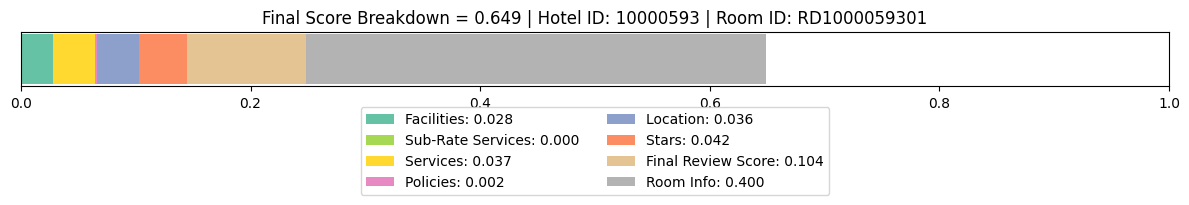

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

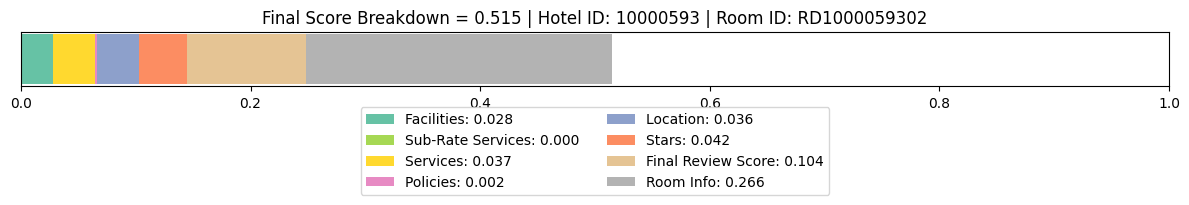

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

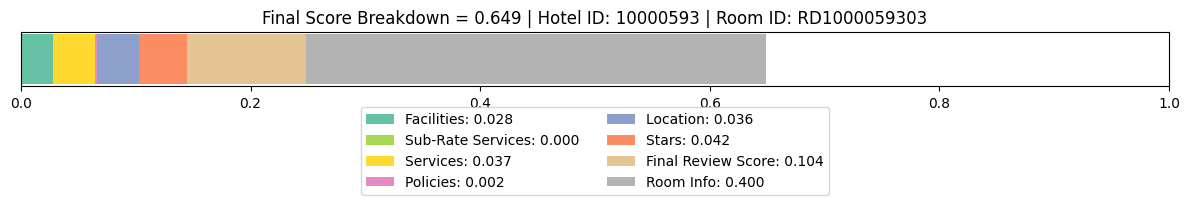

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

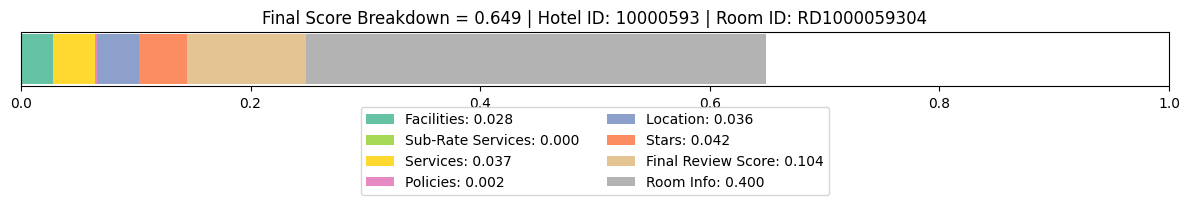

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

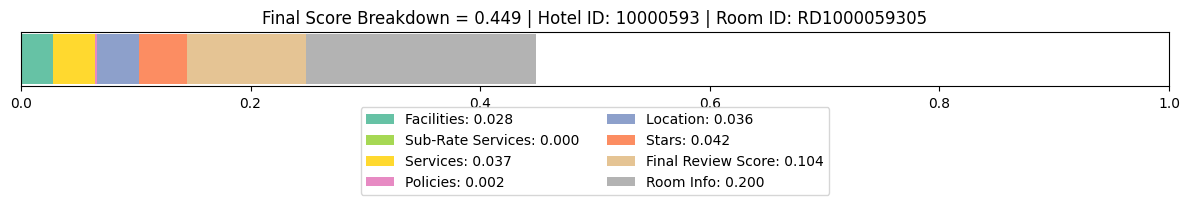

Hotel ID: 10074479 | URL: 
https://www.booking.com/hotel/vn/nham-village-resort.vi.html?checkin=2025-05-25&checkout=2025-05-26

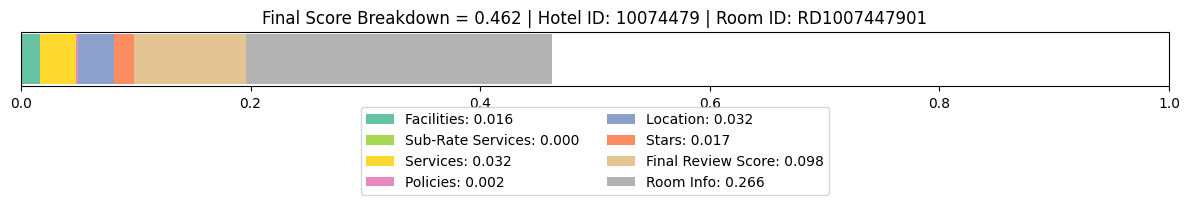

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

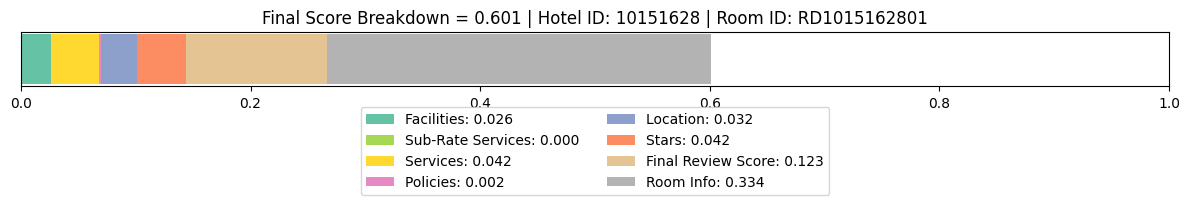

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

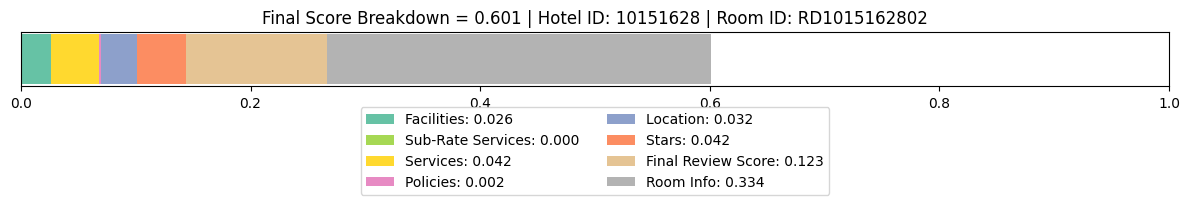

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

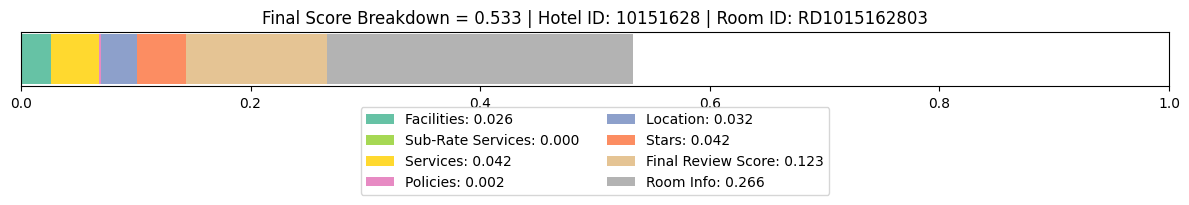

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

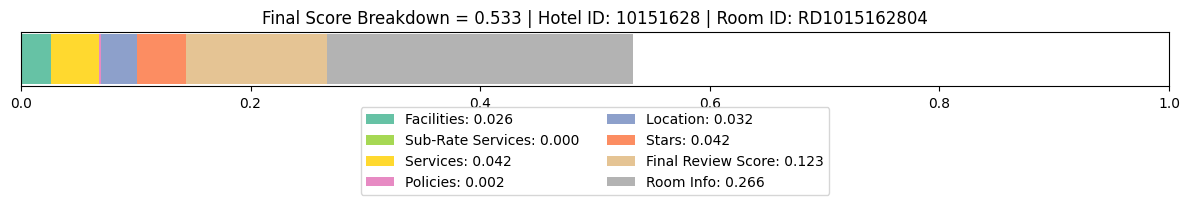

In [ ]:
analyze_results(a, feature_url)